This notebook is used to generate the overlapping LSST cutouts of the Roman images and all the truth and detection catalog information for each of the 16 randomly selected tiles of the Roman Troxel Data.

In [1]:
import sys
sys.path.insert(0, '/global/u2/y/yaswante/gcr-catalogs') 

In [24]:
import os, re, json, time
import numpy as np
import pandas as pd
import multiprocessing as mp
import gc
import random


from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
from astropy.visualization import ZScaleInterval, ImageNormalize, make_lupton_rgb
from scipy.ndimage import zoom 

import lsst.daf.butler as Butler
import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.geom as geom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
from lsst.afw.image import MaskedImage, MultibandExposure
import lsst.afw.table as afw_table
import lsst.afw.display as afwDisplay
from lsst.afw.fits import makeLimitedFitsHeader

import GCRCatalogs
from GCRCatalogs import GCRQuery
import healpy as hp

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from cachetools import cached
from cachetools.keys import hashkey
from multiprocessing import Manager
from functools import lru_cache, partial
from pathlib import Path

In [14]:
GCRCatalogs.__version__

'1.10.1'

In [10]:
# manager for sharing cache b/w processes
manager = Manager()
shared_cache = manager.dict()
pd.options.mode.chained_assignment = None

In [11]:
# --- Setup LSST Butler and Skymap ---
repo = '/global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/rerun/run2.2i-dr6-v2'
butler = dafPersist.Butler(repo)
skymap = butler.get("deepCoadd_skyMap")

# Single Cutout

In [25]:
plt.rcParams['figure.figsize'] = (10, 10)
zscale = ZScaleInterval()
root_dir = '/pscratch/sd/y/yaswante/MyQuota/roman_lsst/'
roman_dir = f'{root_dir}truth-roman/'
lsst_dir = f'{root_dir}truth-lsst/'
ra_dec_dir = '50.93_-42.0'
cutout_id = 1
single_cutout_truth_cat_filename = f'{roman_dir}{ra_dec_dir}/truth_c{cutout_id}_{ra_dec_dir}.json'
roman_img_filename = f'{roman_dir}{ra_dec_dir}/full_c{cutout_id}_{ra_dec_dir}.npy'
single_cutout_truth_cat = pd.read_json(single_cutout_truth_cat_filename, orient='records')

In [26]:
single_cutout_truth_cat

cutout_id    cutout_x    cutout_y        dec  dered_F184  dered_H158  \
0            1  450.908063  496.208090 -42.123696   -0.018838   -0.024395   
1            1  306.195683  384.883688 -42.125472   -0.032458   -0.042388   
2            1  311.026176  164.179591 -42.128997    0.000000    0.000000   
3            1  484.520131  136.106251 -42.129448   -0.113614   -0.146422   
4            1  396.684623  457.830836 -42.124308   -0.020309   -0.026371   
5            1   32.856141  409.002392 -42.125083   -0.019614   -0.025400   
6            1   74.499533  349.491416 -42.126034    0.000000    0.000000   
7            1  355.538177  388.793573 -42.125410   -0.071742   -0.092583   
8            1   41.009744    8.510597 -42.131480    0.000000    0.000000   
9            1  101.243924  416.548324 -42.124964   -0.023955   -0.031023   
10           1  310.955277  104.576768 -42.129949   -0.024891   -0.032196   
11           1  246.271172   75.776898 -42.130408   -0.100690   -0.130249   
12           1  291.136673  260.062990 -42.127465   -0.075174   -0.097179   
13           1  430.912824  171.359221 -42.128884    0.000000    0.000000   
14           1   24.804550  159.473166 -42.129069    0.000000    0.000000   
15           1  319.660146  503.738246 -42.123574    0.000000    0.000000   
16           1  324.961209  503.477417 -42.123578   -0.024829   -0.032345   
17           1  320.409946  230.835816 -42.127933   -0.060661   -0.079529   
18           1  300.545671  218.147557 -42.128135   -0.027314   -0.035209   
19           1    6.412239   30.306880 -42.131131    0.000000    0.000000   
20           1  434.820399  379.057142 -42.125567   -0.030339   -0.039065   
21           1  330.544576  422.792365 -42.124867   -0.027660   -0.035634   
22           1  340.548776  398.177768 -42.125260   -0.028580   -0.036776   
23           1   83.905407  187.057984 -42.128629   -0.019699   -0.026006   
24           1  453.858321  497.501112 -42.123675   -0.031231   -0.040268   
25           1  221.306842   33.304038 -42.131086    0.000000    0.000000   
26           1  442.847532  376.974799 -42.125600    0.000000    0.000000   
27           1  412.821094  218.045285 -42.128138   -0.031840   -0.041073   
28           1  270.573220   57.355448 -42.130703   -0.030794   -0.039718   
29           1   45.788645  487.249684 -42.123834   -0.030685   -0.039462   
..         ...         ...         ...        ...         ...         ...   
105          1  249.140739  480.826736 -42.123939   -0.140778   -0.181055   
106          1  199.121704   55.643865 -42.130729   -0.131708   -0.168196   
107          1  360.374606  232.113878 -42.127913    0.000000    0.000000   
108          1   51.377484  155.869401 -42.129127    0.000000    0.000000   
109          1   96.622079   24.625886 -42.131223   -0.334646   -0.405689   
110          1  118.339613  233.281583 -42.127891   -0.153674   -0.192210   
111          1  105.154351  223.006932 -42.128055   -0.095558   -0.115169   
112          1  116.182924  291.323651 -42.126964   -0.382741   -0.458640   
113          1  224.685334  296.721934 -42.126879   -0.077190   -0.092168   
114          1  279.941543  498.518271 -42.123657   -0.144576   -0.180727   
115          1  480.355975  291.133118 -42.126972   -0.238056   -0.284534   
116          1  144.923668  143.804852 -42.129321   -0.080536   -0.095290   
117          1  145.153876  105.819710 -42.129927   -0.060931   -0.080465   
118          1  345.023459  307.775033 -42.126704   -0.182524   -0.222268   
119          1  355.286531  389.448042 -42.125400   -0.159353   -0.197364   
120          1  471.188344  411.234848 -42.125053    0.000000    0.000000   
121          1  507.560123  376.412739 -42.125610    0.000000    0.000000   
122          1  221.549631  328.869701 -42.126366   -0.083631   -0.099794   
123          1   23.256586  499.695202 -42.123635   -0.226987   -0.282218   
124          1  434.012666  238.818434 -42.127807   -0.088167   -0.102810   
1

## Getting Coord Range and Corners from Cutout Truth Catalog

In [27]:
ra_min, ra_max, dec_min, dec_max = single_cutout_truth_cat['ra'].min(), single_cutout_truth_cat['ra'].max(), single_cutout_truth_cat['dec'].min(), single_cutout_truth_cat['dec'].max()
corners = np.array(
    [(ra_min, dec_min), # bottom left
     (ra_max, dec_min), # bottom right
     (ra_min, dec_max), # top left
     (ra_max, dec_max) # top right
    ]
)
ras, decs = corners[:, 0], corners[:, 1]

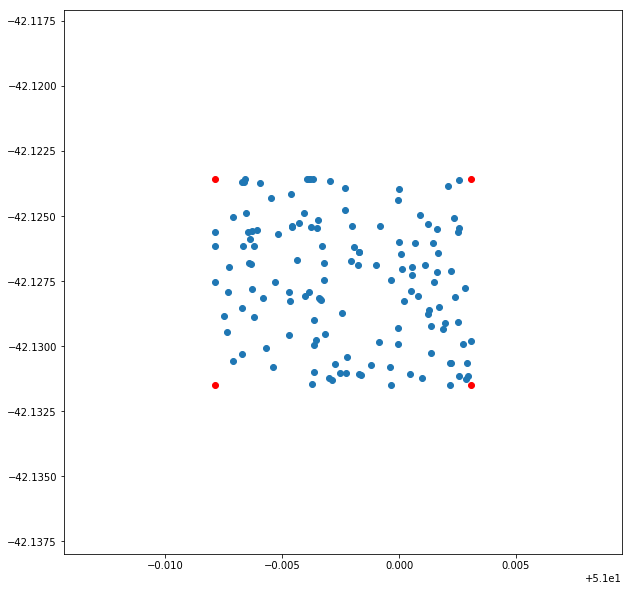

In [9]:
import matplotlib.pyplot as plt
plt.scatter(single_cutout_truth_cat['ra'].values, single_cutout_truth_cat['dec'].values, label='Truth Objects')
for corner in corners:
    plt.scatter(corner[0], corner[1], c=['red'], label='Corners')

## Tract and Patch

In [10]:
def find_tract_patch(ra, dec, skymap):
    """
    Finds LSST tract and patch for a given RA & Dec
    Args:
        ra (np.ndarray) in degrees
        dec (np.ndarray) in degrees
        skymap: LSST skymap object obtained from Butler

    Returns:
        list of tuples: (tract_ids, patch_idxs) or (None, None) if not found
               patch_str is formatted as "x,y"
    """
    try:
        spherePoints = [geom.SpherePoint(r * geom.degrees, d * geom.degrees) for r, d in zip(ra, dec)]
        tracts = [skymap.findTract(spherePoint) for spherePoint in spherePoints]
        patches = [patchInfo.getIndex() for spherePoint, tractInfo in zip(spherePoints, tracts) 
                      for patchInfo in [tractInfo.findPatch(spherePoint)]]
        patch_idxs = [",".join(map(str, idx)) for idx in patches]
        tract_ids = [tractInfo.getId() for tractInfo in tracts]
        # tractInfo = skymap.findTract(spherePoint)
        # patchInfo = tractInfo.findPatch(spherePoint)
        # tract_ids = [tract_patch[0].getId() for tract_patch in tract_patches]
        # patch_idxs = [f"{idx[0]},{idx[1]}"  
        #               for tract_patch in tract_patches
        #               for idx in [tract_patch[1][0].getIndex()]]
        # uses map(str, idx) to convert each ele of idx to a string
        # ",".join to concat them w/ comma 
        # patch_idxs = [",".join(map(str, idx)) 
        #       for tract_patch in tract_patches
        #       for idx in [tract_patch[1][0].getIndex()]]

        return np.array([tract_ids]), np.array([patch_idxs])
    except Exception as e: 
        print(f"Warning: Could not find tract/patch for some RA, Dec: {e}. Not within this skymap")
        return None, None

In [11]:
tracts, patches = find_tract_patch(ras, decs, skymap)
tracts, patches

(array([[3075, 3075, 3075, 3075]]),
 array([['5,4', '5,4', '5,4', '5,4']], dtype='<U3'))

In [12]:
tract = sorted(np.unique(tracts))
patch = sorted(np.unique(patches))
tract, patch

([3075], ['5,4'])

To make our lives easier, we will not find corresponding LSST cutouts for any Roman cutouts where we get more than one unique tract or patch. This would happen when one of the `spherePoints` is near the corner of a tract/patch and exists within an adjacent tract/patch. This usually means the Roman cutout overlaps multiple tracts/patches and butler doesn't play well when we have multiple tracts/patches as the bounding box generated from the ra and dec ranges will be overlapping multiple tracts but you can only pass in one tract and one patch to Butler.

In [13]:
tractID, patch_xy = None, None
if len(tract) == 1 and len(patch) == 1:
    tractID = tract[0]
    patch_xy = patch[0]
else:
    print(f"There exists either multiple tracts or patches: {tract} or {patch}. This cutout will be skipped!") # insert cutout id

In [14]:
tractID, patch_xy

(3075, '5,4')

## Querying Butler

In [15]:
@cached(cache=shared_cache, key=lambda bbox, wcs: hashkey(bbox, wcs)) # caching results of a function so we avoid repeated calculations for the same inputs
def get_coord_range(bbox, wcs):
    """
    Get the coordinate range of the region.

    Notes
    -----
    This method is used to return the ra_range and dec_range needed to calculate healpix_pixels

    Parameters
    ----------
    bbox: Calexp.BBox
        Defines corners of region's bounding box
    wcs: Calexp.Wcs
        Defines pixel to world (sky) coordinate transformation
    """
    region_box = geom.Box2D(bbox)
    corners = region_box.getCorners()
    ras_decs = np.array([(wcs.pixelToSky(corner)[0].asDegrees(),
                          wcs.pixelToSky(corner)[1].asDegrees()) for corner in corners])
    # ra_range, dec_range
    return (np.min(ras_decs[:, 0]), np.max(ras_decs[:, 0])), (np.min(ras_decs[:, 1]), np.max(ras_decs[:, 1]))

In [20]:
def get_cutout_image(butler, tractID, patch_xy, ras, decs, band, skymap, **kwargs):
    # tract info using the provided tractID
    tractInfo = skymap[tractID]
    wcs = tractInfo.getWcs()
    # all corner coords to pixel coords
    radec_points = [geom.SpherePoint(ra * geom.degrees, dec * geom.degrees) 
                for ra, dec in zip(ras, decs)]
    xy_pixels = np.array([[wcs.skyToPixel(radec).getX(), wcs.skyToPixel(radec).getY()] 
                      for radec in radec_points])
    
    # min/max pixel coords to create bbox
    min_coords = np.min(xy_pixels, axis=0)
    max_coords = np.max(xy_pixels, axis=0)
    
    min_x, min_y = min_coords[0], min_coords[1]
    max_x, max_y = max_coords[0], max_coords[1]
    bbox = geom.BoxI(geom.PointI(min_x, min_y), geom.PointI(max_x, max_y))

    # coaddId using provided tractID and patch_xy
    coaddId = {'tract': tractID, 'patch': patch_xy, 'filter': band}
    try:
        # datasetType is deepCoadd
        cutout_image = butler.get('deepCoadd_calexp_sub', bbox=bbox, immediate=True, dataId=coaddId)
    except Exception as e:
        print(f"\nRA: {ras} and DEC: {decs} had an error when querying Butler. \n Error: {e}")
        return (None,) * 6
    
    # for Extragalatic CosmosDC2 catalog, we need to calculate the healpix val and return ra/dec range based on bbox quantities
    ra_range, dec_range = get_coord_range(bbox, wcs)
    vertices = hp.ang2vec(np.array([ra_range[0], ra_range[1],
                                    ra_range[1], ra_range[0]]),
                          np.array([dec_range[0], dec_range[0],
                                    dec_range[1], dec_range[1]]), lonlat=True)
    ipix = hp.query_polygon(32, vertices, inclusive=True)
    
    return cutout_image, tractID, patch_xy, ipix, ra_range, dec_range

In [17]:
lsst_imgs = []
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    lsst_exp, tracts, patches, ipixs, ra_ranges, dec_ranges = get_cutout_image(butler, tractID, patch_xy, ras, decs, band, skymap) 
    lsst_imgs.append(lsst_exp)

## Visualizing Cutout

In [18]:
roman_img = np.load(roman_img_filename)

In [19]:
def stretch_color(data, clipPercent):
    return np.percentile(data, (0 + clipPercent, 100 - clipPercent))

In [15]:
from astropy.visualization import AsinhStretch, MinMaxInterval, ImageNormalize
def asinh_norm(data, a=0.1):
    finite_data = data[np.isfinite(data)] # ensure no NaN or inf vals
    if len(finite_data) == 0:
        return ImageNormalize(vmin=0, vmax=1, stretch=AsinhStretch(a=a))
    # percentile-based limits
    vmin, vmax = np.percentile(finite_data, [1, 99])
    return ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch(a=a))

def plot_asinh(lsst_imgs, roman_img, upsampled_lsst_imgs=None, num_panels=2, cat=None):
    """
    lsst_imgs: list of lsst.afw.image.exposure.exposure.ExposureF given by Butler
    Image array obtained by lsst_img.image.array

    roman_img: Corresponding Roman image of LSST cutout

    num_panels: How many panels to have on the actual plot 
    
    """
    fig, axes = plt.subplots(1, num_panels, figsize=(5 * num_panels, 8)) # 2 for just roman vs lsst, 3 for roman 
    lsst_iband_img = lsst_imgs[3].image.array # lsst i-band img
    axes[0].set_title(r'LSST - $i$ Band')
    axes[0].imshow(lsst_iband_img, norm=asinh_norm(lsst_iband_img, a=0.1), origin='lower', cmap='viridis')
    if cat is not None:
        print("\nPlotting objects from catalog:")
        axes[0].scatter(cat['cutout_x'], cat['cutout_y'], color=['red'], s=8)
        # axes[0].scatter(xs, ys)


    if num_panels == 3:
        upsampled_iband_img = upsampled_lsst_imgs[3]
        axes[1].set_title(r'LSST Upsampled - $i$ Band')
        axes[1].imshow(upsampled_iband_img, norm=asinh_norm(upsampled_iband_img, a=0.1), origin='lower', cmap='viridis')

        
    axes[-1].set_title(r'Roman - $F184$ Band')
    axes[-1].imshow(roman_img[0, :, :], clim=stretch_color(roman_img, 1), cmap='viridis', origin='lower')
        
    plt.tight_layout()

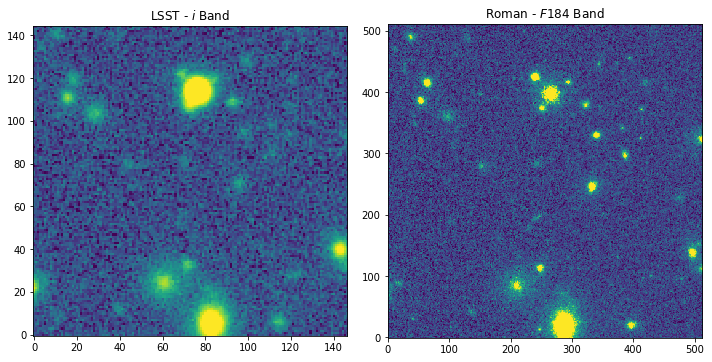

In [41]:
plot_asinh(lsst_imgs, roman_img)

## Bicubic Upsampling LSST Images

In [22]:
from scipy.ndimage import zoom 
# zoom - spline interpolation of a given order (https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html)
# could also use cv2 but not available in conda env (cv2.resize(lsst_img, (roman_dims[1], roman_dims[0]), interpolation=cv2.INTER_CUBIC))

roman_dims = (512, 512)
zoom_y = roman_dims[0] / lsst_imgs[0].image.array.shape[0]
zoom_x = roman_dims[1] / lsst_imgs[0].image.array.shape[1]

# lanczos interpolation
upsampled_lsst_imgs = [zoom(img.image.array, (zoom_y, zoom_x), order=4) for img in lsst_imgs]

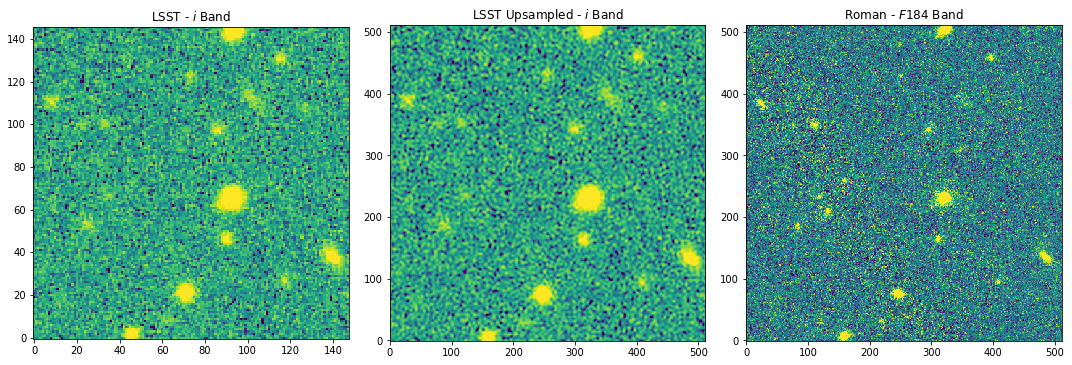

In [23]:
plot_asinh(lsst_imgs, roman_img, upsampled_lsst_imgs=upsampled_lsst_imgs, num_panels=3)

Great! It seems to match our Roman cutout properly. Let's try it for a different cutout. In order to do that, let's first make a function that combines all of the functionality above and then we can just pass in our initial parameters.

In [16]:
ra_dec_dir = '51.53_-40.0'
cutout_id = 90        
single_cutout_truth_cat_filename = f'{roman_dir}{ra_dec_dir}/truth_c{cutout_id}_{ra_dec_dir}.json'
roman_img_filename = f'{roman_dir}{ra_dec_dir}/full_c{cutout_id}_{ra_dec_dir}.npy'
single_cutout_truth_cat = pd.read_json(single_cutout_truth_cat_filename, orient='records')

In [21]:
def process_cutout(cutout_truth_df, roman_img_filename):
    ra_min, ra_max, dec_min, dec_max = single_cutout_truth_cat['ra'].min(), single_cutout_truth_cat['ra'].max(), single_cutout_truth_cat['dec'].min(), single_cutout_truth_cat['dec'].max()
    corners = np.array(
        [(ra_min, dec_min), # bottom left
         (ra_max, dec_min), # bottom right
         (ra_min, dec_max), # top left
         (ra_max, dec_max) # top right
        ]
    )
    ras, decs = corners[:, 0], corners[:, 1]
    tracts, patches = find_tract_patch(ras, decs, skymap)
    tract = sorted(np.unique(tracts))
    patch = sorted(np.unique(patches))
    
    tractID, patch_xy = None, None
    if len(tract) == 1 and len(patch) == 1:
        tractID = tract[0]
        patch_xy = patch[0]
        print(tractID, patch_xy)
    else:
        print(f"There exists either multiple tracts or patches: {tract} or {patch}. This cutout will be skipped!") # insert cutout id
        return

    # lsst_exp, tracts, patches, ipixs, ra_ranges, dec_ranges = get_cutout_image(butler, tractID, patch_xy, ras, decs, 'i', skymap)
    roman_img = np.load(roman_img_filename)
    roman_dims = (512, 512)
    # plot_roman_lsst_img(lsst_exp.image.array, roman_img, band='i', linear_map=True)
    lsst_imgs = []
    for band in ['u', 'g', 'r', 'i', 'z', 'y']:
        lsst_exp, tracts, patches, ipixs, ra_ranges, dec_ranges = get_cutout_image(butler, tractID, patch_xy, ras, decs, band, skymap) 
        lsst_imgs.append(lsst_exp)

    # zoom - spline interpolation of a given order (https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html)
    # could also use cv2 but not available in conda env (cv2.resize(lsst_img, (roman_dims[1], roman_dims[0]), interpolation=cv2.INTER_CUBIC))
    zoom_y = roman_dims[0] / lsst_imgs[0].image.array.shape[0]
    zoom_x = roman_dims[1] / lsst_imgs[0].image.array.shape[1]
    
    # lanczos interpolation
    upsampled_lsst_imgs = [zoom(img.image.array, (zoom_y, zoom_x), order=4) for img in lsst_imgs]

    return lsst_imgs, upsampled_lsst_imgs, roman_img

In [22]:
lsst_imgs, upsampled_lsst_imgs, roman_img = process_cutout(single_cutout_truth_cat, roman_img_filename)

3442 2,0


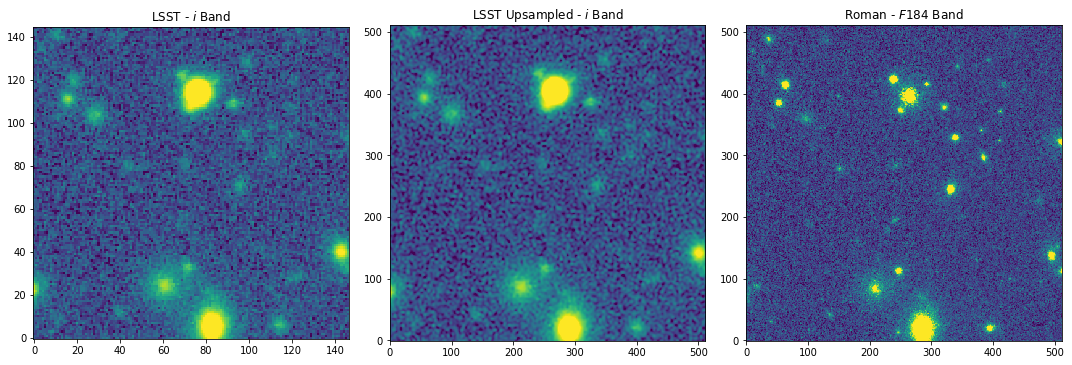

In [27]:
plot_asinh(lsst_imgs, roman_img, upsampled_lsst_imgs=upsampled_lsst_imgs, num_panels=3)

(<Figure size 1152x576 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2c734a588>,
       dtype=object))

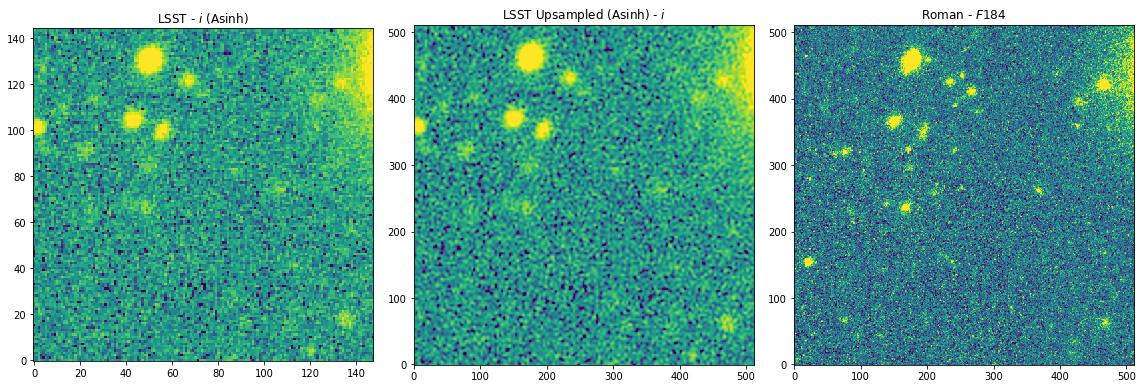

In [36]:
plot_three_asinh(lsst_imgs, roman_img[0, :, :]) # ra_dec_dir = '56.06_-39.8' cutout_id = 124

# Single Cutout LSST Truth and LSST Detection Catalog

In [18]:
ra_dec_dir = '51.53_-40.0'
cutout_id = 90        
single_cutout_truth_cat_filename = f'{roman_dir}{ra_dec_dir}/truth_c{cutout_id}_{ra_dec_dir}.json'
roman_img_filename = f'{roman_dir}{ra_dec_dir}/full_c{cutout_id}_{ra_dec_dir}.npy'
single_cutout_truth_cat = pd.read_json(single_cutout_truth_cat_filename, orient='records')

In [23]:
ra_min, ra_max, dec_min, dec_max = single_cutout_truth_cat['ra'].min(), single_cutout_truth_cat['ra'].max(), single_cutout_truth_cat['dec'].min(), single_cutout_truth_cat['dec'].max()
corners = np.array(
    [(ra_min, dec_min), # bottom left
     (ra_max, dec_min), # bottom right
     (ra_min, dec_max), # top left
     (ra_max, dec_max) # top right
    ]
)
ras, decs = corners[:, 0], corners[:, 1]
tracts, patches = find_tract_patch(ras, decs, skymap)
tract = sorted(np.unique(tracts))
patch = sorted(np.unique(patches))

tractID, patch_xy = None, None
if len(tract) == 1 and len(patch) == 1:
    tractID = tract[0]
    patch_xy = patch[0]
    print(tractID, patch_xy)
else:
    print(f"There exists either multiple tracts or patches: {tract} or {patch}. This cutout will be skipped!") # insert cutout id

# lsst_exp, tracts, patches, ipixs, ra_ranges, dec_ranges = get_cutout_image(butler, tractID, patch_xy, ras, decs, 'i', skymap)
roman_img = np.load(roman_img_filename)
roman_dims = (512, 512)
# plot_roman_lsst_img(lsst_exp.image.array, roman_img, band='i', linear_map=True)
lsst_imgs = []
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    lsst_exp, tracts, patches, ipixs, ra_ranges, dec_ranges = get_cutout_image(butler, tractID, patch_xy, ras, decs, band, skymap) 
    lsst_imgs.append(lsst_exp)

# zoom - spline interpolation of a given order (https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html)
# could also use cv2 but not available in conda env (cv2.resize(lsst_img, (roman_dims[1], roman_dims[0]), interpolation=cv2.INTER_CUBIC))
zoom_y = roman_dims[0] / lsst_imgs[0].image.array.shape[0]
zoom_x = roman_dims[1] / lsst_imgs[0].image.array.shape[1]

# lanczos interpolation
upsampled_lsst_imgs = [zoom(img.image.array, (zoom_y, zoom_x), order=4) for img in lsst_imgs]

3442 2,0


## LSST Truth Catalog

In [24]:
truth_catalog_merged = GCRCatalogs.load_catalog('dc2_run2.2i_truth_merged_summary', config_overwrite={'tracts': tract}) # truth catalog

In [60]:
sorted(truth_catalog_merged.list_all_quantities(include_native=True), key=str.lower)

['av',
 'cosmodc2_hp',
 'cosmodc2_id',
 'dec',
 'flux_g',
 'flux_i',
 'flux_r',
 'flux_u',
 'flux_y',
 'flux_z',
 'host_galaxy',
 'id',
 'id_string',
 'mag_g',
 'mag_i',
 'mag_r',
 'mag_u',
 'mag_y',
 'mag_z',
 'patch',
 'ra',
 'redshift',
 'rv',
 'tract',
 'truth_type']

In [62]:
# Based on https://www.lsst.org/scientists/keynumbers
bands = ['u','g','r','i','z','y']
# max_mag = 26.9
fluxes = [f'flux_{band}' for band in bands]
bandnames = [f'mag_{band}' for band in bands]
# magr_filter = f'{bandnames[2]} < {max_mag}'
# magi_filter = f'{bandnames[3]} < {26.4}' # i and r band mag cut
magi_filter = f'{bandnames[3]} < {29}'
coord_filters = [
    f'ra > {ra_min}',
    f'ra < {ra_max}',
    f'dec > {dec_min}',
    f'dec < {dec_max}'
]
filters = [magi_filter]
# filters = []
filters.extend(coord_filters)
# all needed columns
cols = ['av', 'cosmodc2_hp', 'cosmodc2_id', 'dec', 'host_galaxy', 'id', 'id_string', 
        'ra', 'redshift', 'rv', 'tract', 'truth_type', 'patch'] + bandnames + fluxes

In [63]:
truth_cat_cols = truth_catalog_merged.get_quantities(cols, filters=filters)

In [64]:
print("Number of objects within this cutout:", len(truth_cat_cols['ra']))

Number of objects within this cutout: 195


In [65]:
truth_cat = pd.DataFrame(truth_cat_cols)

In [66]:
truth_cat['tract'].unique()

array([3442])

In [67]:
truth_cat['patch'].unique()

array(['2,0'], dtype=object)

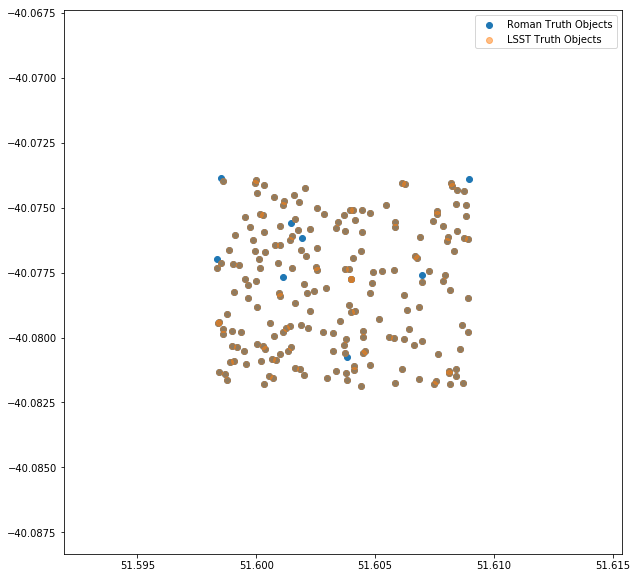

In [76]:
plt.scatter(single_cutout_truth_cat['ra'].values, single_cutout_truth_cat['dec'].values, label='Roman Truth Objects')
# for corner in corners:
#     plt.scatter(corner[0], corner[1], c=['red'], label='Corners')
plt.scatter(truth_cat['ra'], truth_cat['dec'], alpha=0.5, label='LSST Truth Objects')
plt.legend()

In [93]:
cutout_shape = lsst_imgs[3].image.array.shape
wcs = WCS(lsst_imgs[3].getWcs().getFitsMetadata())
subimage_origin = lsst_imgs[3].getXY0()
origin = (subimage_origin.getX(), subimage_origin.getY())

ra_all = truth_cat['ra'].values
dec_all = truth_cat['dec'].values
sky_coords = SkyCoord(ra=ra_all*u.degree, dec=dec_all*u.degree)

xs, ys = wcs.world_to_pixel(sky_coords)
xs -= origin[0]
ys -= origin[1]
inds = np.where((xs>0) & (xs<cutout_shape[1]-1) & (ys>0) & (ys<cutout_shape[0]-1))[0]
dcut = truth_cat.iloc[inds]
dcut.loc[:, 'cutout_x'] = xs[inds]
dcut.loc[:, 'cutout_y'] = ys[inds]
print("After filtering: we have ", len(dcut), " objects.")

After filtering: we have  194  objects.



Plotting objects from catalog:


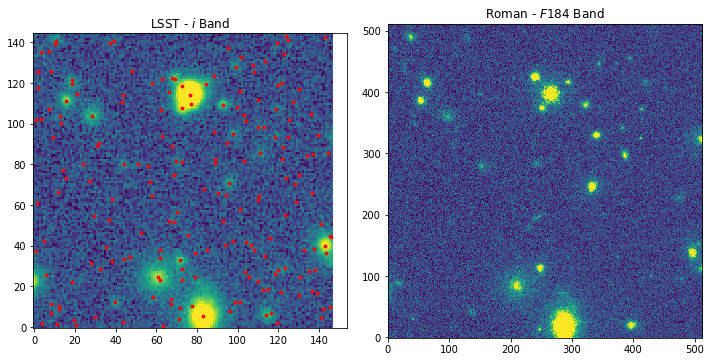

In [98]:
plot_asinh(lsst_imgs, roman_img, cat=dcut)

Great! It looks like we got the right truth catalog objects. Now, let's get all the morphological information for the galaxies in this catalog.

In [108]:
cosmodf = dcut[(dcut['truth_type'] == 1)][['cosmodc2_id', 'cosmodc2_hp']]
print(len(np.unique(cosmodf['cosmodc2_id'])))
cosmodf

193


cosmodc2_id  cosmodc2_hp
1     9440129692        10066
2     9440130676        10066
3     9440140746        10066
4     9440148355        10066
5     9439719041        10066
6     9439740180        10066
7     9439532292        10066
8     9439553442        10066
9     9439596502        10066
10    9439116573        10066
11    9439168740        10066
12    9440007347        10066
13    9440036692        10066
14    9440038157        10066
15    9440038159        10066
16    9440069244        10066
17    9440090775        10066
18    9439418881        10066
19    9439441376        10066
20    9438726517        10066
21    9439001544        10066
22    9439063515        10066
23    9438450020        10066
24    9438489620        10066
25    9438503787        10066
26    9438561776        10066
27    9438565423        10066
28    9438579412        10066
29    9438598189        10066
30    9438825911        10066
..           ...          ...
165   9453808401        10066
166   9453854857        10066
167   9454232326        10066
168   9453580485        10066
169   9453585609        10066
170   9454535420        10066
171   9453607156        10066
172   9454992809        10066
173   9455332894        10066
174   9455388096        10066
175   9454876013        10066
176   9455736095        10066
177   9455741136        10066
178   9455954794        10066
179   9455973855        10066
180   9455432826        10066
181   9455476923        10066
182   9454154816        10066
183   9454900661        10066
184   9454900663        10066
185   9454906306        10066
186   9454913187        10066
187   9457419493        10066
188   9456970828        10066
189   9457921410        10066
190   9457981805        10066
191   9458024474        10066
192   9457687888        10066
193   9456132389        10066
194   9456188763        10066

[193 rows x 2 columns]

In [117]:
healpix_pixels = np.unique(cosmodf['cosmodc2_hp'])
ids = cosmodf['cosmodc2_id']
healpix_pixels, len(ids)

(array([10066]), 193)

### With Morphological Info

In [100]:
gal_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image', config_overwrite={'healpix_pixels': healpix_pixels})

In [101]:
sorted(gal_cat.list_all_quantities(include_native=True), key=str.lower)

['A_v',
 'A_v_bulge',
 'A_v_disk',
 'baseDC2/_obs_sm_orig_um_snap',
 'baseDC2/dec',
 'baseDC2/galaxy_id',
 'baseDC2/halo_id',
 'baseDC2/host_centric_vx',
 'baseDC2/host_centric_vy',
 'baseDC2/host_centric_vz',
 'baseDC2/host_centric_x',
 'baseDC2/host_centric_y',
 'baseDC2/host_centric_z',
 'baseDC2/host_halo_mvir',
 'baseDC2/host_halo_vx',
 'baseDC2/host_halo_vy',
 'baseDC2/host_halo_vz',
 'baseDC2/host_halo_x',
 'baseDC2/host_halo_y',
 'baseDC2/host_halo_z',
 'baseDC2/hostid',
 'baseDC2/is_on_red_sequence_gr',
 'baseDC2/is_on_red_sequence_ri',
 'baseDC2/lightcone_id',
 'baseDC2/lightcone_replication',
 'baseDC2/lightcone_rotation',
 'baseDC2/mpeak',
 'baseDC2/mvir',
 'baseDC2/obs_sfr',
 'baseDC2/obs_sfr_percentile',
 'baseDC2/obs_sm',
 'baseDC2/ra',
 'baseDC2/redshift',
 'baseDC2/restframe_extincted_sdss_abs_magg',
 'baseDC2/restframe_extincted_sdss_abs_magi',
 'baseDC2/restframe_extincted_sdss_abs_magr',
 'baseDC2/restframe_extincted_sdss_gr',
 'baseDC2/restframe_extincted_sdss_ri',

In [114]:
bands = ['u','g','r','i','z','y']
bandnames = [f'mag_{band}' for band in bands]

disk_lums = [f'SDSS_filters/diskLuminositiesStellar:SDSS_{band}:observed' for band in bands if band != 'y']
spheroid_lums = [f'SDSS_filters/spheroidLuminositiesStellar:SDSS_{band}:observed' for band in bands if band != 'y']

magi_filter = [f'{bandnames[3]} < {29}']
coord_filters = [
    f'ra > {ra_min}',
    f'ra < {ra_max}',
    f'dec > {dec_min}',
    f'dec < {dec_max}'
]
redshift_filter = ['redshift > 0']
filters = redshift_filter + coord_filters + magi_filter
# filters = [magr_filter, magi_filter, redshift_filter]
cols_g = ["ra", "dec", "bulge_to_total_ratio_i", "convergence", "ellipticity_1_bulge_true", "ellipticity_1_disk_true",
        "ellipticity_1_true", "ellipticity_2_bulge_true", "ellipticity_2_disk_true", "ellipticity_2_true", 
        "galaxy_id", "mag_true_g", "mag_true_i", "mag_true_r", "mag_true_u", "mag_true_y", "mag_true_z",
        "position_angle_true", "position_angle_true_dc2", "redshift", "shear_1", "shear_2", "size_bulge_true", "size_disk_true",
        "size_minor_disk_true", "size_minor_bulge_true", "size_true", "size_minor_true", "R_v", "A_v", 
       "LSST_filters/spheroidLuminositiesStellar:LSST_y:observed", "LSST_filters/diskLuminositiesStellar:LSST_y:observed",
         "LSST_filters/spheroidLuminositiesStellar:LSST_u:observed", "LSST_filters/diskLuminositiesStellar:LSST_u:observed"] + bandnames + disk_lums + spheroid_lums

In [115]:
all_gal_cat = pd.DataFrame(gal_cat.get_quantities(cols_g, filters=filters))

In [116]:
print(f"Total rows in concatenated df: {all_gal_cat.shape[0]}")

Total rows in concatenated df: 210


In [118]:
filtered_gal_cat = all_gal_cat[all_gal_cat['galaxy_id'].isin(ids)].copy()
print(f"Filtered morphology data down to {len(filtered_gal_cat)} target galaxies.")
# filtered_gal_cat

Filtered morphology data down to 193 target galaxies.


In [120]:
for band in bands:
    if band == 'y':
        filtered_gal_cat[f'bulge_to_total_ratio_y'] = filtered_gal_cat[f'LSST_filters/spheroidLuminositiesStellar:LSST_y:observed']/(filtered_gal_cat[f'LSST_filters/spheroidLuminositiesStellar:LSST_y:observed'] + filtered_gal_cat[f'LSST_filters/diskLuminositiesStellar:LSST_y:observed'])
    elif band == 'u':
        filtered_gal_cat[f'bulge_to_total_ratio_u'] = filtered_gal_cat[f'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed']/(filtered_gal_cat[f'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed'] + filtered_gal_cat[f'LSST_filters/diskLuminositiesStellar:LSST_u:observed'])
    else:
        if band != 'i':
            filtered_gal_cat[f'bulge_to_total_ratio_{band}'] = filtered_gal_cat[f'SDSS_filters/spheroidLuminositiesStellar:SDSS_{band}:observed']/(filtered_gal_cat[f'SDSS_filters/spheroidLuminositiesStellar:SDSS_{band}:observed'] + filtered_gal_cat[f'SDSS_filters/diskLuminositiesStellar:SDSS_{band}:observed'])

In [121]:
filtered_gal_cat.columns

Index(['mag_g', 'SDSS_filters/diskLuminositiesStellar:SDSS_u:observed',
       'ellipticity_1_disk_true', 'mag_true_r', 'mag_true_u', 'mag_u',
       'SDSS_filters/spheroidLuminositiesStellar:SDSS_z:observed',
       'LSST_filters/diskLuminositiesStellar:LSST_u:observed',
       'ellipticity_1_bulge_true', 'mag_r', 'mag_y',
       'SDSS_filters/diskLuminositiesStellar:SDSS_i:observed',
       'ellipticity_2_disk_true', 'ellipticity_1_true', 'galaxy_id',
       'mag_true_i',
       'LSST_filters/spheroidLuminositiesStellar:LSST_y:observed',
       'size_minor_disk_true', 'size_minor_bulge_true',
       'LSST_filters/diskLuminositiesStellar:LSST_y:observed',
       'SDSS_filters/spheroidLuminositiesStellar:SDSS_g:observed',
       'bulge_to_total_ratio_i', 'ellipticity_2_true', 'size_disk_true',
       'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed', 'shear_1',
       'position_angle_true_dc2', 'size_bulge_true',
       'SDSS_filters/spheroidLuminositiesStellar:SDSS_i:observed

### Merging Morphological Info into Truth Catalog

In [123]:
# Ensure no duplicate columns before merge except the key
cols_to_drop = [col for col in filtered_gal_cat.columns if col in dcut.columns and col != 'galaxy_id']
cols_to_drop

['mag_g', 'mag_u', 'mag_r', 'mag_y', 'mag_i', 'redshift', 'ra', 'mag_z', 'dec']

In [131]:
filtered_gal_cat_renamed = filtered_gal_cat.drop(columns=cols_to_drop).rename(columns={'galaxy_id': 'cosmodc2_id'})

In [132]:
filtered_gal_cat_renamed.columns

Index(['SDSS_filters/diskLuminositiesStellar:SDSS_u:observed',
       'ellipticity_1_disk_true', 'mag_true_r', 'mag_true_u',
       'SDSS_filters/spheroidLuminositiesStellar:SDSS_z:observed',
       'LSST_filters/diskLuminositiesStellar:LSST_u:observed',
       'ellipticity_1_bulge_true',
       'SDSS_filters/diskLuminositiesStellar:SDSS_i:observed',
       'ellipticity_2_disk_true', 'ellipticity_1_true', 'cosmodc2_id',
       'mag_true_i',
       'LSST_filters/spheroidLuminositiesStellar:LSST_y:observed',
       'size_minor_disk_true', 'size_minor_bulge_true',
       'LSST_filters/diskLuminositiesStellar:LSST_y:observed',
       'SDSS_filters/spheroidLuminositiesStellar:SDSS_g:observed',
       'bulge_to_total_ratio_i', 'ellipticity_2_true', 'size_disk_true',
       'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed', 'shear_1',
       'position_angle_true_dc2', 'size_bulge_true',
       'SDSS_filters/spheroidLuminositiesStellar:SDSS_i:observed', 'shear_2',
       'SDSS_filters

In [133]:
print("Merging morphology data...")
# Perform the merge
truth_cat_morph = dcut.merge(
    filtered_gal_cat_renamed,
    on='cosmodc2_id',
    how='left',
    suffixes=('_truth_merged', '_cosmodc2')
)
print("Merge complete.")

Merging morphology data...
Merge complete.


In [134]:
truth_cat_morph

mag_g  host_galaxy  cosmodc2_id           id         flux_y  \
0    19.802313           -1           -1  40897455295  120434.765625   
1    28.949965           -1   9440129692   9440129692      22.990196   
2    28.861393           -1   9440130676   9440130676      58.835285   
3    27.957558           -1   9440140746   9440140746      58.494568   
4    29.492693           -1   9440148355   9440148355      31.775986   
5    29.287182           -1   9439719041   9439719041      36.334465   
6    27.371162           -1   9439740180   9439740180      88.081558   
7    28.844442           -1   9439532292   9439532292      25.338531   
8    28.607161           -1   9439553442   9439553442     217.175476   
9    27.651657           -1   9439596502   9439596502      46.455818   
10   29.462557           -1   9439116573   9439116573      29.469328   
11   27.516724           -1   9439168740   9439168740     109.146233   
12   28.586119           -1   9440007347   9440007347      81.721458   
13   27.377338           -1   9440036692   9440036692     138.479828   
14   27.037575           -1   9440038157   9440038157    3202.265869   
15   24.637642           -1   9440038159   9440038159    1594.966553   
16   28.396133           -1   9440069244   9440069244      32.878391   
17   28.236511           -1   9440090775   9440090775      66.107895   
18   27.837624           -1   9439418881   9439418881     114.461098   
19   29.742085           -1   9439441376   9439441376      75.492180   
20   27.883415           -1   9438726517   9438726517      85.504684   
21   27.656136           -1   9439001544   9439001544     245.260742   
22   28.598324           -1   9439063515   9439063515      25.339424   
23   28.738585           -1   9438450020   9438450020      55.931580   
24   29.686909           -1   9438489620   9438489620      26.144428   
25   29.470758           -1   9438503787   9438503787      47.402229   
26   28.075134           -1   9438561776   9438561776      80.392593   
27   28.709652           -1   9438565423   9438565423      51.451141   
28   28.060408           -1   9438579412   9438579412     118.021217   
29   29.648607           -1   9438598189   9438598189      31.545029   
..         ...          ...          ...          ...            ...   
164  28.933437           -1   9453808401   9453808401      27.160246   
165  28.668325           -1   9453854857   9453854857       9.171700   
166  25.794758           -1   9454232326   9454232326     205.201675   
167  28.484844           -1   9453580485   9453580485      29.836750   
168  26.806986           -1   9453585609   9453585609      57.316437   
169  27.897469           -1   9454535420   9454535420      20.241888   
170  27.141209           -1   9453607156   9453607156      78.010452   
171  28.793419           -1   9454992809   9454992809      10.436984   
172  28.808613           -1   9455332894   9455332894       8.786053   
173  28.259127           -1   9455388096   9455388096      13.596307   
174  29.282114           -1   9454876013   9454876013      19.705328   
175  27.102224           -1   9455736095   9455736095      43.818638   
176  27.420645           -1   9455741136   9455741136      28.367882   
177  28.954906           -1   9455954794   9455954794      16.138046   
178  29.196323           -1   9455973855   9455973855      10.905838   
179  28.427544           -1   9455432826   9455432826      11.688982   
180  27.839777           -1   9455476923   9455476923      42.472527   
181  26.321775           -1   9454154816   9454154816     122.879074   
182  26.931965           -1   9454900661   9454900661      78.953278   
183  28.346222           -1   9454900663   9454900663      30.880096   
184  28.475376           -1   9454906306   9454906306      38.235939   
185  28.766121           -1   9454913187   9454913187      32.648289   
186  28.891420           -1   9457419493   9457419493       8.260465   
187  30.604486           -1   9456970828   945697

In [135]:
truth_cat_filename = f'{lsst_dir}dc2_{ra_dec_dir}/truth_c{cutout_id}_{ra_dec_dir}.json'
truth_cat_morph.to_json(truth_cat_filename, orient='records')

## LSST Detection Catalog

In [138]:
GCRCatalogs.get_available_catalog_names()

['buzzard',
 'buzzard_high-res',
 'cosmoDC2_v1.1.4_image',
 'cosmoDC2_v1.1.4_redmagic_v0.8.1_highdens',
 'cosmoDC2_v1.1.4_redmagic_v0.8.1_highlum',
 'cosmoDC2_v1.1.4_redmapper_v0.8.1',
 'cosmoDC2_v1.1.4_small',
 'cosmoDC2_v1.1.4_wazp_v1.0_flexzboost_v1',
 'cosmoDC2_v1.1.4_wazp_v1.0_truez',
 'dc2_object_run1.2i',
 'dc2_object_run1.2i_all_columns',
 'dc2_object_run1.2i_tract4850',
 'dc2_object_run1.2i_with_photoz',
 'dc2_object_run1.2p',
 'dc2_object_run1.2p_all_columns',
 'dc2_object_run1.2p_tract4850',
 'dc2_object_run2.2i_dr2_wfd',
 'dc2_object_run2.2i_dr2_wfd_with_addons',
 'dc2_object_run2.2i_dr3a',
 'dc2_object_run2.2i_dr3a_with_metacal',
 'dc2_object_run2.2i_dr3a_with_photoz',
 'dc2_object_run2.2i_dr6',
 'dc2_object_run2.2i_dr6_v2_with_addons_v2',
 'dc2_object_run2.2i_dr6_with_addons',
 'dc2_redmagic_run2.2i_dr6_wfd_v0.8.1_highdens',
 'dc2_redmagic_run2.2i_dr6_wfd_v0.8.1_highlum',
 'dc2_redmapper_run2.2i_dr6_wfd_v0.8.1',
 'dc2_run2.2i_truth_galaxy_summary',
 'dc2_run2.2i_truth_mer

Object catalog contains information about static astronomical objects measured on a stacked (coadd) image. The photometry in the Object catalog is measured with the forced photometry method, i.e., it is consistently measured across multiple bands using a fixed position, which is determined from the reference filter for each source (the filter that best measures the source).

`dc2_object_run2.2i_dr6_v2_with_addons_v2` has 'cosmodc2_hp_truth', 'cosmodc2_id_truth' 'flux_g_truth', 'flux_i_truth', 'flux_r_truth', 'flux_u_truth', 'flux_y_truth', 'flux_z_truth', 'truth_type' columns but `config_overwrite={'tracts': tract})` doesn't work. It produces this error:

```python
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<ipython-input-141-13ce82b3a329> in <module>
----> 1 test = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_v2_with_addons_v2', config_overwrite={'tracts': tract, 'skymap': 'DC2'})

/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/register.py in load_catalog(catalog_name, config_overwrite)
    377     """
    378     check_for_reg()
--> 379     return ConfigSource.config_source[catalog_name].load_catalog(config_overwrite)  # pylint: disable=unsubscriptable-object
    380 
    381 

/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/base_config.py in load_catalog(self, config_overwrite)
    144         else:
    145             config_dict = self._resolved_content
--> 146         return load_catalog_from_config_dict(config_dict)
    147 
    148 

/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/base_config.py in load_catalog_from_config_dict(catalog_config)
    324     return import_subclass(
    325         catalog_config[BaseConfig.READER_KEY], __package__, BaseGenericCatalog
--> 326     )(**catalog_config)

/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/composite.py in __init__(self, **kwargs)
     16         for catalog_dict in kwargs['catalogs']:
     17             catalog_name = catalog_dict.get('catalog_name') or catalog_dict.get('based_on')
---> 18             if has_catalog(catalog_name):
     19                 catalog = load_catalog(catalog_name, catalog_dict)
     20             elif 'subclass_name' in catalog_dict:

/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/register.py in has_catalog(catalog_name, include_pseudo)
    347     """
    348     check_for_reg()
--> 349     lower_name = catalog_name.lower()
    350     if lower_name in ConfigSource.config_source._configs:
    351         the_name = lower_name

AttributeError: 'NoneType' object has no attribute 'lower'
```

`dc2_object_run2.2i_dr6_v2` does work with `config_overwrite` but doesn't have those columns. So, for now, until we find a fix for the above error, we will go ahead with this catalog.

In [142]:
det_catalog = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_v2', config_overwrite={'tracts': tract})

In [137]:
sorted(det_catalog.list_all_quantities(include_native=True), key=str.lower)

['base_Blendedness_abs',
 'base_Blendedness_abs_child_instFlux',
 'base_Blendedness_abs_child_xx',
 'base_Blendedness_abs_child_xy',
 'base_Blendedness_abs_child_yy',
 'base_Blendedness_abs_parent_instFlux',
 'base_Blendedness_abs_parent_xx',
 'base_Blendedness_abs_parent_xy',
 'base_Blendedness_abs_parent_yy',
 'base_Blendedness_flag',
 'base_Blendedness_flag_noCentroid',
 'base_Blendedness_flag_noShape',
 'base_Blendedness_old',
 'base_Blendedness_raw',
 'base_Blendedness_raw_child_instFlux',
 'base_Blendedness_raw_child_xx',
 'base_Blendedness_raw_child_xy',
 'base_Blendedness_raw_child_yy',
 'base_Blendedness_raw_parent_instFlux',
 'base_Blendedness_raw_parent_xx',
 'base_Blendedness_raw_parent_xy',
 'base_Blendedness_raw_parent_yy',
 'base_CircularApertureFlux_12_0_flag',
 'base_CircularApertureFlux_12_0_flag_apertureTruncated',
 'base_CircularApertureFlux_12_0_flag_sincCoeffsTruncated',
 'base_CircularApertureFlux_12_0_instFlux',
 'base_CircularApertureFlux_12_0_instFluxErr',
 'b

In [150]:
# Based on https://www.lsst.org/scientists/keynumbers
# https://lsstdesc.org/DC2-analysis/tutorials/object_gcr_1_intro.html
bands = ['u','g','r','i','z','y']
# max_mag = 26.9
bandnames = [f'mag_{band}' for band in bands]
psf_fwhm_asec = [f'psf_fwhm_{band}' for band in bands]
# magr_filter = f'{bandnames[2]} < {max_mag}'
magi_filter = f'{bandnames[3]} < {29}' # i band mag cut
coord_filters = [
    f'ra > {ra_min}',
    f'ra < {ra_max}',
    f'dec > {dec_min}',
    f'dec < {dec_max}'
]
filters = [magi_filter] + coord_filters
# 'cosmodc2_hp_truth', 'cosmodc2_id_truth' 'flux_g_truth', 'flux_i_truth', 'flux_r_truth', 'flux_u_truth', 'flux_y_truth', 'flux_z_truth', 'truth_type'
# all above don't exist in dc2_obj without addons
cols_det = ['objectId', 'parentObjectId', 'x', 'y', 'ra', 'dec', 'extendedness', 'mag_u_cModel', 'mag_g_cModel', 'mag_r_cModel', 
    'snr_u_cModel', 'snr_g_cModel', 'snr_r_cModel', 'snr_i_cModel', 'snr_z_cModel', 'snr_y_cModel',
    'mag_i_cModel', 'mag_z_cModel', 'mag_y_cModel', 'good', 'clean', 'blendedness', 'tract', 'patch'] + bandnames + psf_fwhm_asec

In [177]:
det_cat = pd.DataFrame(det_catalog.get_quantities(cols_det, filters=filters, native_filters=f'(tract == {tract[0]})'))

/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


In [178]:
print(f"Number of detected objects within this cutout: {len(det_cat)}")

Number of detected objects within this cutout: 39


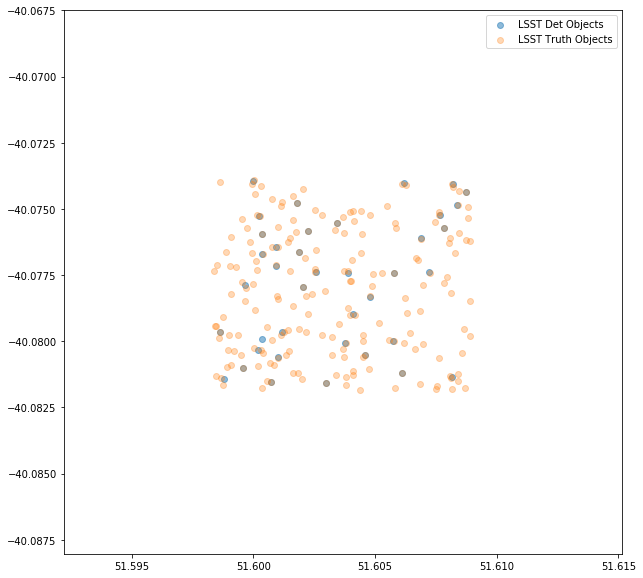

In [179]:
# plt.scatter(single_cutout_truth_cat['ra'].values, single_cutout_truth_cat['dec'].values, label='Roman Truth Objects')
plt.scatter(det_cat['ra'].values, det_cat['dec'].values, alpha=0.5, label='LSST Det Objects')
plt.scatter(truth_cat['ra'].values, truth_cat['dec'].values, alpha=0.3, label='LSST Truth Objects')
plt.legend()

In [180]:
ra_all = det_cat['ra'].values
dec_all = det_cat['dec'].values
det_sky_coords = SkyCoord(ra=ra_all*u.degree, dec=dec_all*u.degree)

xs, ys = wcs.world_to_pixel(det_sky_coords)
xs -= origin[0]
ys -= origin[1]
inds = np.where((xs>0) & (xs<cutout_shape[1]-1) & (ys>0) & (ys<cutout_shape[0]-1))[0]
det_dcut = det_cat.iloc[inds]
det_dcut.loc[:, 'cutout_x'] = xs[inds]
det_dcut.loc[:, 'cutout_y'] = ys[inds]
print("After filtering: we have ", len(det_dcut), " objects.")

After filtering: we have  39  objects.



Plotting objects from catalog:


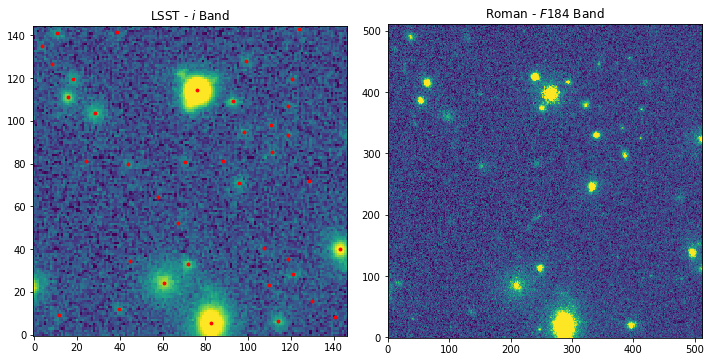

In [181]:
plot_asinh(lsst_imgs, roman_img, cat=det_dcut)

In [182]:
det_cat_filename = f'{lsst_dir}dc2_{ra_dec_dir}/det_c{cutout_id}_{ra_dec_dir}.json'
det_dcut.to_json(det_cat_filename, orient='records')

Great! We've been able to save both the full truth and detection catalog for a single cutout. Now, we need to scale this up for every single cutout we have.

# Saving All Cutouts and their Truth and Detection Catalogs

In [2]:
import sys
sys.path.insert(0, '/global/u2/y/yaswante/gcr-catalogs')
import os, re, json, time
import numpy as np
import pandas as pd
import multiprocessing as mp
import gc
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
from scipy.ndimage import zoom

import lsst.daf.butler as Butler
import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.geom as geom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
from lsst.afw.image import MaskedImage, MultibandExposure
import lsst.afw.table as afw_table
from lsst.afw.fits import makeLimitedFitsHeader

import GCRCatalogs
from GCRCatalogs import GCRQuery
import healpy as hp

from cachetools import cached
from cachetools.keys import hashkey
from multiprocessing import Manager
from functools import lru_cache, partial
import pyarrow.parquet as pq

In [3]:
print("GCR Catalogs Version: ", GCRCatalogs.__version__)
pd.options.mode.chained_assignment = None

GCR Catalogs Version:  1.10.1


## Helper Functions

In [4]:
def get_truth_catalog_by_tract(tract_id, patch):
    """Loads and caches the TRUTH catalog using a file-based cache"""
    key = hashkey('truth', tract_id, patch)
    cache_filepath = os.path.join(FILE_CACHE_DIR, f'truth_{key}.parquet')
    tmp_filepath = f"{cache_filepath}.{os.getpid()}.tmp" # Unique temp file per process   
    
    if os.path.exists(cache_filepath):
        print(f"FILE CACHE HIT: Loading TRUTH from {cache_filepath}")
        return pd.read_parquet(cache_filepath)

    # if file doesn't exist, we might need to create it
    # we use a lock to ensure only one process creates the file
    with lock:
        # After acquiring the lock, we check AGAIN if another process created it
        # while this one was waiting (double-checked lock)
        if os.path.exists(cache_filepath):
            print(f"FILE CACHE HIT (after lock): Loading TRUTH from {cache_filepath}")
            return pd.read_parquet(cache_filepath)

        print(f"FILE CACHE MISS: Loading TRUTH for tract {tract_id}, patch {patch}")
        # Based on https://www.lsst.org/scientists/keynumbers
        bands = ['u', 'g', 'r', 'i', 'z', 'y']
        bandnames = [f'mag_{band}' for band in bands]
        magi_filter = f'{bandnames[3]} < {29}'
        fluxes = [f'flux_{band}' for band in bands]
        cols_truth = ['av', 'cosmodc2_hp', 'cosmodc2_id', 'dec', 'host_galaxy', 'id', 'id_string', 
        'ra', 'redshift', 'rv', 'tract', 'truth_type', 'patch'] + bandnames + fluxes
        truth_catalog_merged = GCRCatalogs.load_catalog('dc2_run2.2i_truth_merged_summary', config_overwrite={'tracts': [tract_id]})
        truth_cat_cols = truth_catalog_merged.get_quantities(cols_truth, filters=[magi_filter])
        truth_cat = pd.DataFrame(truth_cat_cols)
        truth_cat_patch = truth_cat[truth_cat['patch'] == patch]

        # write to the tmp file first
        truth_cat_patch.to_parquet(tmp_filepath)
        # Atomically rename the temp file to the final file path
        os.rename(tmp_filepath, cache_filepath)
        print(f"FILE CACHE CREATED: Saved to {cache_filepath}")
        
        return {col: np.array(truth_cat_patch[col]) for col in truth_cat_patch.columns}

def get_galaxy_morphology_by_hp(healpix_pixels):
    """
    Ensures the morphology catalog file exists in the cache and returns its path
    """
    key = hashkey(healpix_pixels)
    cache_filepath = os.path.join(FILE_CACHE_DIR, f'morphology_{key}.parquet')
    tmp_filepath = f"{cache_filepath}.{os.getpid()}.tmp" # uniq temp file per process   

    if os.path.exists(cache_filepath):
        print(f"FILE CACHE HIT: Returning GALAXY MORPHOLOGY from {cache_filepath}")
        return cache_filepath

    with lock:
        if os.path.exists(cache_filepath):
            print(f"FILE CACHE HIT (after lock): Returning GALAXY MORPHOLOGY from {cache_filepath}")
            return cache_filepath

        # we must create the file if we get here
        print(f"FILE CACHE MISS: Creating GALAXY MORPHOLOGY file for {healpix_pixels}")

        bands = ['u', 'g', 'r', 'i', 'z', 'y']
        bandnames = [f'mag_{band}' for band in bands]
        magi_filter = f'{bandnames[3]} < 29'
        redshift_filter = ['redshift > 0']
        filters = redshift_filter + [magi_filter]
            
        disk_lums = [f'SDSS_filters/diskLuminositiesStellar:SDSS_{band}:observed' for band in bands if band != 'y']
        spheroid_lums = [f'SDSS_filters/spheroidLuminositiesStellar:SDSS_{band}:observed' for band in bands if band != 'y']
        cols_morph = ["ra", "dec", "bulge_to_total_ratio_i", "convergence", "ellipticity_1_bulge_true", "ellipticity_1_disk_true",
                "ellipticity_1_true", "ellipticity_2_bulge_true", "ellipticity_2_disk_true", "ellipticity_2_true", 
                "galaxy_id", "mag_true_g", "mag_true_i", "mag_true_r", "mag_true_u", "mag_true_y", "mag_true_z",
                "position_angle_true", "position_angle_true_dc2", "redshift", "shear_1", "shear_2", "size_bulge_true", "size_disk_true",
                "size_minor_disk_true", "size_minor_bulge_true", "size_true", "size_minor_true", "R_v", "A_v", 
               "LSST_filters/spheroidLuminositiesStellar:LSST_y:observed", "LSST_filters/diskLuminositiesStellar:LSST_y:observed",
                 "LSST_filters/spheroidLuminositiesStellar:LSST_u:observed", "LSST_filters/diskLuminositiesStellar:LSST_u:observed"] + bandnames + disk_lums + spheroid_lums
        
        gal_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image', config_overwrite={'healpix_pixels': list(healpix_pixels)})
        gal_cat_cols = pd.DataFrame(gal_cat.get_quantities(cols_morph, filters=filters))

        # write to the tmp file first
        gal_cat_cols.to_parquet(tmp_filepath)
        # Atomically rename the temp file to the final file path
        os.rename(tmp_filepath, cache_filepath)
        
        print(f"FILE CACHE CREATED: Saved to {cache_filepath}")
        del gal_cat_cols
        return cache_filepath

def get_detection_catalog_by_tract(tract_id, patch):
    """Loads and caches the DETECTION catalog using a file-based cache"""
    key = hashkey('det', tract_id, patch)
    cache_filepath = os.path.join(FILE_CACHE_DIR, f'det_{key}.parquet')
    tmp_filepath = f"{cache_filepath}.{os.getpid()}.tmp" # uniq temp file per process   
    
    if os.path.exists(cache_filepath):
        print(f"FILE CACHE HIT: Loading DET from {cache_filepath}")
        return pd.read_parquet(cache_filepath)
    
    # If file doesn't exist, we might need to create it
    # we use a lock to ensure only one process creates the file
    with lock:
        # After acquiring the lock, we check AGAIN if another process created it
        # while this one was waiting (double-checked lock)
        if os.path.exists(cache_filepath):
            print(f"FILE CACHE HIT (after lock): Loading DET from {cache_filepath}")
            return pd.read_parquet(cache_filepath)

        print(f"FILE CACHE MISS: Loading DET for tract {tract_id}, patch {patch}")
        bands = ['u', 'g', 'r', 'i', 'z', 'y']
        bandnames = [f'mag_{band}' for band in bands]
        magi_filter = f'{bandnames[3]} < {29}'
        psf_fwhm_asec = [f'psf_fwhm_{band}' for band in bands]
        # 'cosmodc2_hp_truth', 'cosmodc2_id_truth' 'flux_g_truth', 'flux_i_truth', 'flux_r_truth', 'flux_u_truth', 'flux_y_truth', 'flux_z_truth', 'truth_type'
        # all above don't exist in dc2_obj without addons
        cols_det = ['objectId', 'parentObjectId', 'x', 'y', 'ra', 'dec', 'extendedness', 'mag_u_cModel', 'mag_g_cModel', 'mag_r_cModel', 
            'snr_u_cModel', 'snr_g_cModel', 'snr_r_cModel', 'snr_i_cModel', 'snr_z_cModel', 'snr_y_cModel',
            'mag_i_cModel', 'mag_z_cModel', 'mag_y_cModel', 'good', 'clean', 'blendedness', 'tract', 'patch'] + bandnames + psf_fwhm_asec
        det_catalog = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_v2', config_overwrite={'tracts': [tract_id]})
        det_cat = pd.DataFrame(det_catalog.get_quantities(cols_det, filters=[magi_filter], native_filters=f'(tract == {tract_id})'))
        det_cat_patch = det_cat[det_cat['patch'] == patch]
        # write to the tmp file first
        det_cat_patch.to_parquet(tmp_filepath)
        # Atomically rename the temp file to the final file path
        os.rename(tmp_filepath, cache_filepath)
        
        print(f"FILE CACHE CREATED: Saved to {cache_filepath}")
        
        return {col: np.array(det_cat_patch[col]) for col in det_cat_patch.columns}

@cached(cache=shared_cache, key=lambda bbox, wcs: hashkey(bbox, wcs)) # caching results of a function so we avoid repeated calculations for the same inputs
def get_coord_range(bbox, wcs):
    """
    Get the coordinate range of the region.

    Notes
    -----
    This method is used to return the ra_range and dec_range needed to calculate healpix_pixels

    Parameters
    ----------
    bbox: Calexp.BBox
        Defines corners of region's bounding box
    wcs: Calexp.Wcs
        Defines pixel to world (sky) coordinate transformation
    """
    region_box = geom.Box2D(bbox)
    corners = region_box.getCorners()
    ras_decs = np.array([(wcs.pixelToSky(corner)[0].asDegrees(),
                          wcs.pixelToSky(corner)[1].asDegrees()) for corner in corners])
    # ra_range, dec_range
    return (np.min(ras_decs[:, 0]), np.max(ras_decs[:, 0])), (np.min(ras_decs[:, 1]), np.max(ras_decs[:, 1]))

In [5]:
def find_tract_patch(ra, dec, skymap):
    """
    Finds LSST tract and patch for a given RA & Dec
    Args:
        ra (np.ndarray) in degrees
        dec (np.ndarray) in degrees
        skymap: LSST skymap object obtained from Butler

    Returns:
        list of tuples: (tract_ids, patch_idxs) or (None, None) if not found
               patch_str is formatted as "x,y"
    """
    try:
        spherePoints = [geom.SpherePoint(r * geom.degrees, d * geom.degrees) for r, d in zip(ra, dec)]
        tracts = [skymap.findTract(spherePoint) for spherePoint in spherePoints]
        patches = [patchInfo.getIndex() for spherePoint, tractInfo in zip(spherePoints, tracts) 
                      for patchInfo in [tractInfo.findPatch(spherePoint)]]
        patch_idxs = [",".join(map(str, idx)) for idx in patches]
        tract_ids = [tractInfo.getId() for tractInfo in tracts]

        return np.array([tract_ids]), np.array([patch_idxs])
    except Exception as e: 
        print(f"Warning: Could not find tract/patch for some RA, Dec: {e}. Not within this skymap")
        return None, None

def get_cutout_image(butler, tractID, patch_xy, ras, decs, band, skymap, **kwargs):
    # tract info using the provided tractID
    tractInfo = skymap[tractID]
    wcs = tractInfo.getWcs()
    # all corner coords to pixel coords
    radec_points = [geom.SpherePoint(ra * geom.degrees, dec * geom.degrees) 
                for ra, dec in zip(ras, decs)]
    xy_pixels = np.array([[wcs.skyToPixel(radec).getX(), wcs.skyToPixel(radec).getY()] 
                      for radec in radec_points])
    
    # min/max pixel coords to create bbox
    min_x, min_y = np.min(xy_pixels, axis=0)
    max_x, max_y = np.max(xy_pixels, axis=0)
    bbox = geom.BoxI(geom.PointI(min_x, min_y), geom.PointI(max_x, max_y))

    # coaddId using provided tractID and patch_xy
    coaddId = {'tract': tractID, 'patch': patch_xy, 'filter': band}
    try:
        # datasetType is deepCoadd
        cutout_image = butler.get('deepCoadd_calexp_sub', bbox=bbox, immediate=True, dataId=coaddId)
    except Exception as e:
        print(f"\nRA: {ras} and DEC: {decs} had an error when querying Butler. \n Error: {e}")
        return None
    
    return cutout_image

def create_empty_outputs(ra_dec_dir, cutout_id):
    """Creates a full set of empty output files for a failed cutout"""
    print(f"Creating empty output files for failed cutout {cutout_id} in {ra_dec_dir}...")
    
    lsst_path = f'{LSST_DIR}dc2_{ra_dec_dir}/'
    ups_path = f'{LSST_UPS_DIR}dc2_{ra_dec_dir}/'
    os.makedirs(lsst_path, exist_ok=True)
    os.makedirs(ups_path, exist_ok=True)

    base_filename = f'c{cutout_id}_{ra_dec_dir}'
    files_to_create = {
        'lsst_img': f'{lsst_path}full_{base_filename}.npy',
        'ups_img': f'{ups_path}full_{base_filename}.npy',
        'lsst_truth': f'{lsst_path}truth_{base_filename}.json',
        'ups_truth': f'{ups_path}truth_{base_filename}.json',
        'lsst_det': f'{lsst_path}det_{base_filename}.json',
        'ups_det': f'{ups_path}det_{base_filename}.json'
    }

    # empty NumPy arrays for images (6 bands, 0x0 size)
    empty_image_array = np.zeros((6, 0, 0), dtype=np.float32)
    np.save(files_to_create['lsst_img'], empty_image_array)
    np.save(files_to_create['ups_img'], empty_image_array)

    # empty JSON files for catalogs
    empty_df = pd.DataFrame([])
    empty_df.to_json(files_to_create['lsst_truth'], orient='records')
    empty_df.to_json(files_to_create['ups_truth'], orient='records')
    empty_df.to_json(files_to_create['lsst_det'], orient='records')
    empty_df.to_json(files_to_create['ups_det'], orient='records')

## Main Process to Parallelize

In [1]:
def process_cutout(args):
    """
    Main function to process a single cutout which will be distributed to worker processes
    try...finally block to ensure empty files are created on any failure
    """
    ra_dec_dir, cutout_id = args
    success = False  # status flag
    print(f"Processing cutout {cutout_id} for tile {ra_dec_dir}...")
    try:
        single_cutout_truth_cat_filename = f'{ROMAN_DIR}{ra_dec_dir}/truth_c{cutout_id}_{ra_dec_dir}.json'
        if not os.path.exists(single_cutout_truth_cat_filename):
            print(f"This Roman {single_cutout_truth_cat_filename} doesn't exist! Moving on!")
            return (ra_dec_dir, cutout_id, None) # Skip if file doesn't exist
        
        single_cutout_truth_cat = pd.read_json(single_cutout_truth_cat_filename, orient='records')
        if single_cutout_truth_cat.empty:
            print(f"This Roman {single_cutout_truth_cat} is empty! Moving on!")
            return (ra_dec_dir, cutout_id, None)
        
        ra_min, ra_max, dec_min, dec_max = single_cutout_truth_cat['ra'].min(), single_cutout_truth_cat['ra'].max(), single_cutout_truth_cat['dec'].min(), single_cutout_truth_cat['dec'].max()
        corners = np.array(
            [(ra_min, dec_min), # bottom left
             (ra_max, dec_min), # bottom right
             (ra_min, dec_max), # top left
             (ra_max, dec_max) # top right
            ]
        )
        ras, decs = corners[:, 0], corners[:, 1]
        tracts, patches = find_tract_patch(ras, decs, SKYMAP)
        
        if tracts is None or not (len(np.unique(tracts)) == 1 and len(np.unique(patches)) == 1):
            print(f"There exists either multiple tracts or patches: {tracts} or {patches}. OR there exists no tracts! This cutout will be skipped!") # insert cutout id
            return (ra_dec_dir, cutout_id, None)
        
        tract_id = np.unique(tracts)[0]
        patch_xy = np.unique(patches)[0]
        # print(tract_id, patch_xy)
    
        # 2. Get LSST Cutouts
        lsst_imgs = []
        bands = ['u', 'g', 'r', 'i', 'z', 'y']
        skip_current = False
        for band in bands:
            lsst_exp = get_cutout_image(BUTLER, tract_id, patch_xy, ras, decs, band, SKYMAP)
            if lsst_exp is None:
                print(f"Error when processing cutout {cutout_id} for tile {ra_dec_dir}. Moving onto next cutout!")
                skip_current = True
                break # exit this loop bc if an error arises due to the bbox in one band, the same error will be present in all the bands
            lsst_imgs.append(lsst_exp.image.array)
            if band == 'i': # just grab wcs/subimage origin from a single band since each cutout in same area will all have the same one
                wcs = WCS(lsst_exp.getWcs().getFitsMetadata())
                subimage_origin = lsst_exp.getXY0()
                origin = (subimage_origin.getX(), subimage_origin.getY())
                cutout_shape = lsst_exp.image.array.shape
                # to save the right WCS relative to cutout, we need to reset the origin
                lsst_exp.setXY0(geom.PointI(0, 0))
                wcs_header = makeLimitedFitsHeader(lsst_exp.getWcs().getFitsMetadata())
                
        if skip_current:
            return (ra_dec_dir, cutout_id, None) # move on to the next cutout
    
        # 3. SAVE IMAGES (Original and Upsampled)    
        os.makedirs(f'{LSST_DIR}dc2_{ra_dec_dir}/', exist_ok=True)
        os.makedirs(f'{LSST_UPS_DIR}dc2_{ra_dec_dir}/', exist_ok=True)
        np.save(f'{LSST_DIR}dc2_{ra_dec_dir}/full_c{cutout_id}_{ra_dec_dir}.npy', np.asarray(lsst_imgs))
        
        # zoom - spline interpolation of a given order (https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html)
        # could also use cv2 but not available in conda env (cv2.resize(lsst_img, (roman_dims[1], roman_dims[0]), interpolation=cv2.INTER_CUBIC))
        roman_dims = (512, 512)
        zoom_y, zoom_x = roman_dims[0] / cutout_shape[0], roman_dims[1] / cutout_shape[1]    
        upsampled_lsst_imgs = [zoom(img, (zoom_y, zoom_x), order=4) for img in lsst_imgs] # lanczos interpolation
        np.save(f'{LSST_UPS_DIR}dc2_{ra_dec_dir}/full_c{cutout_id}_{ra_dec_dir}.npy', np.asarray(upsampled_lsst_imgs))
        del upsampled_lsst_imgs
        del lsst_imgs
        # 4. PROCESS TRUTH CATALOG
        truth_cat = pd.DataFrame(get_truth_catalog_by_tract(tract_id, patch_xy))
        cutout_truth_cat = truth_cat[
            (truth_cat['ra'] > ra_min) & 
            (truth_cat['ra'] < ra_max) & 
            (truth_cat['dec'] > dec_min) & 
            (truth_cat['dec'] < dec_max)
        ]
        # print("Number of objects within this cutout:", len(cutout_truth_cat['ra']))
        # filtering any objects that are outside the pixel boundaries of cutout        
        sky_coords = SkyCoord(ra=cutout_truth_cat['ra'].values*u.degree, dec=cutout_truth_cat['dec'].values*u.degree)
        xs, ys = wcs.world_to_pixel(sky_coords)
        xs -= origin[0]
        ys -= origin[1]
        inds = np.where((xs > 0) & (xs < cutout_shape[1]-1) & (ys > 0) & (ys < cutout_shape[0]-1))[0]
        dcut = cutout_truth_cat.iloc[inds]
        dcut.loc[:, 'cutout_x'] = xs[inds]
        dcut.loc[:, 'cutout_y'] = ys[inds]    
        # print("After filtering: we have ", len(dcut), " objects.")
    
        # Add Morphology Info
        galaxies = dcut[(dcut['truth_type'] == 1)] # galaxies
        if not galaxies.empty:
            cosmodf = galaxies[['cosmodc2_id', 'cosmodc2_hp']]
            galaxy_ids = cosmodf['cosmodc2_id'].unique()
            # print(len(galaxy_ids), " galaxies in this cutout!")
            healpix_pixels = sorted(cosmodf['cosmodc2_hp'].unique())
            # print(len(healpix_pixels), " healpixels in this cutout!")
            
            # Read the entire file first, then filter in pandas
            morphology_cache_path = get_galaxy_morphology_by_hp(healpix_pixels)
            print(f"Cutout {cutout_id}: Waiting to read morphology data...")
            with lock:
                print(f"Cutout {cutout_id}: Reading morphology data...")
                try:
                    gal_cat = pd.read_parquet(morphology_cache_path)
                    print(f"Cutout {cutout_id}: Morphology data loaded, filtering...")
                except Exception as e:
                    print(f"Cutout {cutout_id}: Error reading morphology file: {e}")
                    raise

            cutout_gal_cat = gal_cat[
                (gal_cat['ra'] > ra_min) & 
                (gal_cat['ra'] < ra_max) & 
                (gal_cat['dec'] > dec_min) & 
                (gal_cat['dec'] < dec_max)
            ]
            # filters to read only the necessary rows from the Parquet file
            # parquet_filters = [
            #     ('ra', '>', ra_min),
            #     ('ra', '<', ra_max),
            #     ('dec', '>', dec_min),
            #     ('dec', '<', dec_max)
            # ]
            # cutout_gal_cat = pd.read_parquet(morphology_cache_path, filters=parquet_filters)
            filtered_gal_cat = cutout_gal_cat[cutout_gal_cat['galaxy_id'].isin(galaxy_ids)].copy()
            # print(f"Filtered morphology data down to {len(filtered_gal_cat)} target galaxies.")
            for band in bands:
                if band == 'y':
                    filtered_gal_cat[f'bulge_to_total_ratio_y'] = filtered_gal_cat[f'LSST_filters/spheroidLuminositiesStellar:LSST_y:observed']/(filtered_gal_cat[f'LSST_filters/spheroidLuminositiesStellar:LSST_y:observed'] + filtered_gal_cat[f'LSST_filters/diskLuminositiesStellar:LSST_y:observed'])
                elif band == 'u':
                    filtered_gal_cat[f'bulge_to_total_ratio_u'] = filtered_gal_cat[f'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed']/(filtered_gal_cat[f'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed'] + filtered_gal_cat[f'LSST_filters/diskLuminositiesStellar:LSST_u:observed'])
                else:
                    if band != 'i':
                        filtered_gal_cat[f'bulge_to_total_ratio_{band}'] = filtered_gal_cat[f'SDSS_filters/spheroidLuminositiesStellar:SDSS_{band}:observed']/(filtered_gal_cat[f'SDSS_filters/spheroidLuminositiesStellar:SDSS_{band}:observed'] + filtered_gal_cat[f'SDSS_filters/diskLuminositiesStellar:SDSS_{band}:observed'])
            cols_to_drop = [col for col in filtered_gal_cat.columns if col in dcut.columns and col != 'galaxy_id']
            filtered_gal_cat_renamed = filtered_gal_cat.drop(columns=cols_to_drop).rename(columns={'galaxy_id': 'cosmodc2_id'})
            # print("Merging morphology data...")
            dcut = dcut.merge(
                filtered_gal_cat_renamed,
                on='cosmodc2_id',
                how='left',
                suffixes=('_truth_merged', '_cosmodc2')
            )
            # print("Merge complete.")
    
        dcut.to_json(f'{LSST_DIR}dc2_{ra_dec_dir}/truth_c{cutout_id}_{ra_dec_dir}.json', orient='records')
        print("Scaling truth catalog coordinates for upsampled image...")
        truth_upsampled = dcut.copy()
        truth_upsampled['cutout_x'] *= zoom_x
        truth_upsampled['cutout_y'] *= zoom_y
        upsampled_truth_filename = f'{LSST_UPS_DIR}dc2_{ra_dec_dir}/truth_c{cutout_id}_{ra_dec_dir}.json'
        truth_upsampled.to_json(upsampled_truth_filename, orient='records')
    
        # 5. PROCESS DETECTION CATALOG
        # det_cat = pd.DataFrame(det_catalog.get_quantities(cols_det, filters=filters, native_filters=f'(tract == {tract_id})'))
        det_cat = pd.DataFrame(get_detection_catalog_by_tract(tract_id, patch_xy))
        cutout_det_cat = det_cat[
            (det_cat['ra'] > ra_min) & 
            (det_cat['ra'] < ra_max) & 
            (det_cat['dec'] > dec_min) & 
            (det_cat['dec'] < dec_max)
        ]
        # print(f"Number of detected objects within this cutout: {len(cutout_det_cat)}")
        
        if not cutout_det_cat.empty:
            det_sky_coords = SkyCoord(ra=cutout_det_cat['ra'].values*u.degree, dec=cutout_det_cat['dec'].values*u.degree)
            xs_det, ys_det = wcs.world_to_pixel(det_sky_coords)
            xs_det -= origin[0]
            ys_det -= origin[1]
            inds_det = np.where((xs_det > 0) & (xs_det < cutout_shape[1]-1) & (ys_det > 0) & (ys_det < cutout_shape[0]-1))[0]
            det_dcut = det_cat.iloc[inds_det]
            det_dcut.loc[:, 'cutout_x'] = xs_det[inds_det]
            det_dcut.loc[:, 'cutout_y'] = ys_det[inds_det]
            # print("After filtering: we have ", len(det_dcut), " objects.")
    
        det_dcut.to_json(f'{LSST_DIR}dc2_{ra_dec_dir}/det_c{cutout_id}_{ra_dec_dir}.json', orient='records')
        print("Scaling detection catalog coordinates for upsampled image...")
        det_upsampled = det_dcut.copy()
        det_upsampled['cutout_x'] = det_upsampled['cutout_x'] * zoom_x
        det_upsampled['cutout_y'] = det_upsampled['cutout_y'] * zoom_y
        upsampled_det_filename = f'{LSST_UPS_DIR}dc2_{ra_dec_dir}/det_c{cutout_id}_{ra_dec_dir}.json'
        det_upsampled.to_json(upsampled_det_filename, orient='records')
    
        del truth_cat, det_dcut, det_upsampled, dcut, truth_upsampled
        if not gal_cat.empty:
            del gal_cat
        
        gc.collect()
        success = True
        print(f"Finished cutout {cutout_id} for tile {ra_dec_dir}.")    
        return (ra_dec_dir, cutout_id, wcs_header)
    finally:
        # GUARANTEED to run, whether the try block succeeded,
        # failed with an exception, or hit a return statement
        if not success:
            create_empty_outputs(ra_dec_dir, cutout_id)

After multiple experiments, we found that for 16 tiles using, 
- **128** processes 
- **chunk size** of **64**

produced all the cutouts and corresponding catalogs, on average, the fastest with a time of ~10.526 minutes per tile.

## Main 

### 16 tiles (128 Cores, 64 chunk size)

In [ ]:
if __name__ == '__main__':
    # --- SHARED CACHE SETUP ---
    # Manager and shared cache are initialized globally so decorators can access them
    # safe as the manager process is only started when the Pool is created
    # allows us to share cache between processes
    manager = mp.Manager() 
    shared_cache = manager.dict()
    lock = manager.Lock() # lock to prevent race conditions (for us, it's when two workers try to create the same file)
    
    FILE_CACHE_DIR = '/pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/'
    os.makedirs(FILE_CACHE_DIR, exist_ok=True)
    
    print(50*"=")
    print("Setting up Directories")
    print(50*"=")
    ROOT_DIR = '/pscratch/sd/y/yaswante/MyQuota/roman_lsst/'
    ROMAN_DIR = f'{ROOT_DIR}truth-roman/'
    LSST_DIR = f'{ROOT_DIR}truth-lsst/'
    LSST_UPS_DIR = f'{ROOT_DIR}truth-lsst-ups/'
    print("Root directory:", ROOT_DIR)
    print("Roman directory:", ROMAN_DIR)
    print("LSST directory:", LSST_DIR)
    print("LSST upsampled directory:", LSST_UPS_DIR)
    print(50*"=")
    print("Setting up LSST Butler and Initializing Skymap")
    print(50*"=")
    repo = '/global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/rerun/run2.2i-dr6-v2'
    BUTLER = dafPersist.Butler(repo)
    SKYMAP = BUTLER.get("deepCoadd_skyMap")
    print("Butler initialized with deepCoadd_skyMap.")
    # output dirs if they don't exist
    os.makedirs(LSST_DIR, exist_ok=True)
    os.makedirs(LSST_UPS_DIR, exist_ok=True)
    
    all_ra_dec_dirs = [
        "50.93_-38.8", "50.93_-42.0", "51.34_-41.3", "51.37_-38.3",
        "51.53_-40.0", "52.31_-41.6", "52.40_-41.1", "52.49_-39.1",
        "52.93_-40.8", "53.25_-41.8", "53.75_-38.9", "54.24_-38.3",
        "54.31_-41.6", "55.03_-41.9", "55.54_-41.9", "56.06_-39.8"
    ]
    print("Here are the tiles we will be processing:")
    for tile in all_ra_dec_dirs:
        print(f"- {tile}")
    
    num_processes = 128 # FROM TESTING
    chunk_size = 64 # FROM TESTING
    print(f"\nStarting chunked processing with {num_processes} workers and chunk size {chunk_size}")
    
    start_time = time.time()
    os.environ["OMP_NUM_THREADS"] = "1"
    
    all_wcs_data = {}
    
    # processing each tile sequentially to avoid mem buildup
    for tile in all_ra_dec_dirs:
        print(f"\n{'='*50}")
        print(f"Processing tile: {tile}")
        print(f"{'='*50}")
        
        tile_wcs_data = {}
        all_cutout_ids = range(225)
        
        for chunk_start in range(0, len(all_cutout_ids), chunk_size):
            chunk_end = min(chunk_start + chunk_size, len(all_cutout_ids))
            chunk_ids = all_cutout_ids[chunk_start:chunk_end]
            
            print(f"\nProcessing chunk: cutouts {chunk_start} to {chunk_end-1}")
            
            # tasks for this chunk only
            chunk_tasks = [(tile, cid) for cid in chunk_ids]
            
            with mp.Pool(processes=num_processes, maxtasksperchild=1) as pool: # MAX TASK PER CHILD = 1
                chunk_results = pool.map(process_cutout, chunk_tasks)
                
                for result in chunk_results:
                    if result:
                        ra_dec_dir, cutout_id, wcs_header_string = result
                        if wcs_header_string is not None:
                            tile_wcs_data[cutout_id] = wcs_header_string
            
            gc.collect()
            print(f"Chunk complete. Memory cleaned.")
        
        if tile_wcs_data:
            all_wcs_data[tile] = tile_wcs_data
            
            # save WCS immediately for this tile
            wcs_df = pd.DataFrame(list(tile_wcs_data.items()), columns=['cutout_id', 'wcs_header'])
            
            wcs_filename_lsst = f'{LSST_DIR}dc2_{tile}/wcs_{tile}.json'
            wcs_df.to_json(wcs_filename_lsst, orient='records')
            
            wcs_filename_ups = f'{LSST_UPS_DIR}dc2_{tile}/wcs_{tile}.json'
            wcs_df.to_json(wcs_filename_ups, orient='records')
            
            print(f"Saved WCS data for tile {tile}")
        
        del tile_wcs_data
        gc.collect()
    
    print("\nAll tasks finished successfully.")
    end_time = time.time()
    print(f"Total time: {end_time - start_time:.2f} seconds")

### 3 tiles (128 Cores, 64 chunk size)

For the below cell, we processed 3 tiles using, 
- **128** processes 
- **chunk size** of **64**

in a total time of 1894.68 seconds or ~31.578 mins meaning ~10.526 mins per tile.

In [7]:
if __name__ == '__main__':
    manager = mp.Manager() 
    shared_cache = manager.dict()
    lock = manager.Lock() 
    
    FILE_CACHE_DIR = '/pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/'
    os.makedirs(FILE_CACHE_DIR, exist_ok=True)
    
    print(50*"=")
    print("Setting up Directories")
    print(50*"=")
    ROOT_DIR = '/pscratch/sd/y/yaswante/MyQuota/roman_lsst/'
    ROMAN_DIR = f'{ROOT_DIR}truth-roman/'
    LSST_DIR = f'{ROOT_DIR}truth-lsst/'
    LSST_UPS_DIR = f'{ROOT_DIR}truth-lsst-ups/'
    print("Root directory:", ROOT_DIR)
    print("Roman directory:", ROMAN_DIR)
    print("LSST directory:", LSST_DIR)
    print("LSST upsampled directory:", LSST_UPS_DIR)
    print(50*"=")
    print("Setting up LSST Butler and Initializing Skymap")
    print(50*"=")
    repo = '/global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/rerun/run2.2i-dr6-v2'
    BUTLER = dafPersist.Butler(repo)
    SKYMAP = BUTLER.get("deepCoadd_skyMap")
    print("Butler initialized with deepCoadd_skyMap.")
    # output dirs if they don't exist
    os.makedirs(LSST_DIR, exist_ok=True)
    os.makedirs(LSST_UPS_DIR, exist_ok=True)
    
    # all_ra_dec_dirs = [d for d in os.listdir(ROMAN_DIR) if os.path.isdir(os.path.join(ROMAN_DIR, d))][1:]
    all_ra_dec_dirs = ["53.25_-41.8", "50.93_-38.8", "50.93_-42.0"] # 30 mins in total
    #                    , "51.53_-40.0", , "51.37_-38.3",
    #     "52.31_-41.6", "52.40_-41.1", "52.49_-39.1", "52.93_-40.8", "53.25_-41.8",
    #     "53.75_-38.9", "54.24_-38.3", "54.31_-41.6", "55.03_-41.9", "55.54_-41.9",
    #     "56.06_-39.8"
    # ]
    # "55.03_-41.9"
    print("Here are the tiles we will be processing:")
    for tile in all_ra_dec_dirs:
        print(f"- {tile}")
    
    num_processes = 128
    chunk_size = 64
    
    print(f"\nStarting chunked processing with {num_processes} workers and chunk size {chunk_size}")
    
    start_time = time.time()
    os.environ["OMP_NUM_THREADS"] = "1"
    
    all_wcs_data = {}
    
    for tile in all_ra_dec_dirs:
        print(f"\n{'='*50}")
        print(f"Processing tile: {tile}")
        print(f"{'='*50}")
        
        tile_wcs_data = {}
        all_cutout_ids = range(225)
        
        for chunk_start in range(0, len(all_cutout_ids), chunk_size):
            chunk_end = min(chunk_start + chunk_size, len(all_cutout_ids))
            chunk_ids = all_cutout_ids[chunk_start:chunk_end]
            
            print(f"\nProcessing chunk: cutouts {chunk_start} to {chunk_end-1}")
            
            chunk_tasks = [(tile, cid) for cid in chunk_ids]
            
            with mp.Pool(processes=num_processes, maxtasksperchild=1) as pool:
                chunk_results = pool.map(process_cutout, chunk_tasks)
                
                for result in chunk_results:
                    if result:
                        ra_dec_dir, cutout_id, wcs_header_string = result
                        if wcs_header_string is not None:
                            tile_wcs_data[cutout_id] = wcs_header_string
            
            gc.collect()
            print(f"Chunk complete. Memory cleaned.")
        
        if tile_wcs_data:
            all_wcs_data[tile] = tile_wcs_data
            
            wcs_df = pd.DataFrame(list(tile_wcs_data.items()), columns=['cutout_id', 'wcs_header'])
            
            wcs_filename_lsst = f'{LSST_DIR}dc2_{tile}/wcs_{tile}.json'
            wcs_df.to_json(wcs_filename_lsst, orient='records')
            
            wcs_filename_ups = f'{LSST_UPS_DIR}dc2_{tile}/wcs_{tile}.json'
            wcs_df.to_json(wcs_filename_ups, orient='records')
            
            print(f"Saved WCS data for tile {tile}")
        
        del tile_wcs_data
        gc.collect()
    
    print("\nAll tasks finished successfully.")
    end_time = time.time()
    print(f"Total time: {end_time - start_time:.2f} seconds")

Setting up Directories
Root directory: /pscratch/sd/y/yaswante/MyQuota/roman_lsst/
Roman directory: /pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-roman/
LSST directory: /pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst/
LSST upsampled directory: /pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst-ups/
Setting up LSST Butler and Initializing Skymap
Butler initialized with deepCoadd_skyMap.
Here are the tiles we will be processing:
- 53.25_-41.8
- 50.93_-38.8
- 50.93_-42.0

Starting chunked processing with 128 workers and chunk size 64

Processing tile: 53.25_-41.8

Processing chunk: cutouts 0 to 63
Processing cutout 0 for tile 53.25_-41.8...Processing cutout 6 for tile 53.25_-41.8...Processing cutout 8 for tile 53.25_-41.8...Processing cutout 14 for tile 53.25_-41.8...Processing cutout 4 for tile 53.25_-41.8...Processing cutout 2 for tile 53.25_-41.8...Processing cutout 12 for tile 53.25_-41.8...Processing cutout 13 for tile 53.25_-41.8...Processing cutout 1 for tile 53.25_-41.

/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


FILE CACHE CREATED: Saved to /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3442, '4,5').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3442, '4,5').parquet
FILE CACHE MISS: Loading DET for tract 3442, patch 4,6
Scaling detection catalog coordinates for upsampled image...
Scaling detection catalog coordinates for upsampled image...
Finished cutout 0 for tile 50.93_-38.8.
Finished cutout 15 for tile 50.93_-38.8.


/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


FILE CACHE CREATED: Saved to /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3442, '4,6').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3442, '4,6').parquet
FILE CACHE MISS: Loading DET for tract 3442, patch 5,5
Scaling detection catalog coordinates for upsampled image...
Scaling detection catalog coordinates for upsampled image...
Finished cutout 45 for tile 50.93_-38.8.
Finished cutout 60 for tile 50.93_-38.8.


/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


FILE CACHE CREATED: Saved to /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3442, '5,5').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3442, '5,5').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3442, '5,5').parquet
Scaling detection catalog coordinates for upsampled image...
Scaling detection catalog coordinates for upsampled image...
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3442, '5,5').parquet
Scaling detection catalog coordinates for upsampled image...
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3442, '5,5').parquet
Scaling detection catalog coordinates for upsampled image...
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3442, '5,5').parquet
Scaling detection catal

/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


FILE CACHE CREATED: Saved to /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3442, '5,6').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3442, '5,6').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3442, '5,6').parquet
Scaling detection catalog coordinates for upsampled image...
Scaling detection catalog coordinates for upsampled image...
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3442, '5,6').parquet
Scaling detection catalog coordinates for upsampled image...
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3442, '5,6').parquet
Scaling detection catalog coordinates for upsampled image...
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3442, '5,5').parquet
Scaling detection catal

/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


FILE CACHE CREATED: Saved to /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '5,4').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '5,4').parquet
FILE CACHE MISS: Loading TRUTH for tract 3075, patch 6,4
Scaling detection catalog coordinates for upsampled image...
Scaling detection catalog coordinates for upsampled image...
Finished cutout 33 for tile 50.93_-42.0.
Finished cutout 60 for tile 50.93_-42.0.
FILE CACHE CREATED: Saved to /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/truth_('truth', 3075, '6,4').parquet
FILE CACHE HIT (after lock): Loading TRUTH from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/truth_('truth', 3075, '6,4').parquet
FILE CACHE HIT (after lock): Loading TRUTH from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/truth_('truth', 3075, '6,4').parquet
FILE CACHE HIT (after lock): Loading TRUTH from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/truth_('truth', 3075, '6,4').parquet
F

/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


FILE CACHE CREATED: Saved to /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '6,4').parquet
Cutout 6: Reading morphology data...
Scaling detection catalog coordinates for upsampled image...
Finished cutout 50 for tile 50.93_-42.0.
Cutout 6: Morphology data loaded, filtering...
Cutout 58: Reading morphology data...
Scaling truth catalog coordinates for upsampled image...
FILE CACHE HIT: Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '6,4').parquet
Scaling detection catalog coordinates for upsampled image...
Finished cutout 6 for tile 50.93_-42.0.
Cutout 58: Morphology data loaded, filtering...
Cutout 21: Reading morphology data...
Scaling truth catalog coordinates for upsampled image...
FILE CACHE HIT: Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '6,4').parquet
Scaling detection catalog coordinates for upsampled image...
Finished cutout 58 for tile 50.93_-42.0.
Cutout 21: Morphology data loaded, filter

/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


FILE CACHE CREATED: Saved to /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '5,5').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '5,5').parquet
FILE CACHE MISS: Loading TRUTH for tract 3075, patch 6,5
Scaling detection catalog coordinates for upsampled image...Scaling detection catalog coordinates for upsampled image...

Finished cutout 166 for tile 50.93_-42.0.
Finished cutout 153 for tile 50.93_-42.0.
FILE CACHE CREATED: Saved to /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/truth_('truth', 3075, '6,5').parquet
FILE CACHE HIT (after lock): Loading TRUTH from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/truth_('truth', 3075, '6,5').parquet
FILE CACHE HIT (after lock): Loading TRUTH from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/truth_('truth', 3075, '6,5').parquet
FILE CACHE HIT: Returning GALAXY MORPHOLOGY from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/morphology_([10194],).parquet
Cutou

/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


FILE CACHE CREATED: Saved to /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '6,5').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '6,5').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '6,5').parquet
Scaling detection catalog coordinates for upsampled image...Scaling detection catalog coordinates for upsampled image...

FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '6,5').parquet
Scaling detection catalog coordinates for upsampled image...
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '6,5').parquet
Scaling detection catalog coordinates for upsampled image...
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '6,5').parquet
Scaling detection catal

### 1 tile (128 Cores, 32 chunk size)

For the below cell, we processed 1 tile using, 
- **128** processes 
- **chunk size** of **32**

in a total time of 599.07 seconds or ~9.9833 mins per tile.

In [61]:
if __name__ == '__main__':
    manager = mp.Manager() 
    shared_cache = manager.dict()
    lock = manager.Lock() 
    
    FILE_CACHE_DIR = '/pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/'
    os.makedirs(FILE_CACHE_DIR, exist_ok=True)
    
    print(50*"=")
    print("Setting up Directories")
    print(50*"=")
    ROOT_DIR = '/pscratch/sd/y/yaswante/MyQuota/roman_lsst/'
    ROMAN_DIR = f'{ROOT_DIR}truth-roman/'
    LSST_DIR = f'{ROOT_DIR}truth-lsst/'
    LSST_UPS_DIR = f'{ROOT_DIR}truth-lsst-ups/'
    print("Root directory:", ROOT_DIR)
    print("Roman directory:", ROMAN_DIR)
    print("LSST directory:", LSST_DIR)
    print("LSST upsampled directory:", LSST_UPS_DIR)
    print(50*"=")
    print("Setting up LSST Butler and Initializing Skymap")
    print(50*"=")
    repo = '/global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/rerun/run2.2i-dr6-v2'
    BUTLER = dafPersist.Butler(repo)
    SKYMAP = BUTLER.get("deepCoadd_skyMap")
    print("Butler initialized with deepCoadd_skyMap.")
    # output dirs if they don't exist
    os.makedirs(LSST_DIR, exist_ok=True)
    os.makedirs(LSST_UPS_DIR, exist_ok=True)
    
    # all_ra_dec_dirs = [d for d in os.listdir(ROMAN_DIR) if os.path.isdir(os.path.join(ROMAN_DIR, d))][0:1]
    all_ra_dec_dirs = ["51.34_-41.3"]
    print("Here are the tiles we will be processing:")
    for tile in all_ra_dec_dirs:
        print(f"- {tile}")
    
    num_processes = 128
    chunk_size = 32
    
    print(f"\nStarting chunked processing with {num_processes} workers and chunk size {chunk_size}")
    
    start_time = time.time()
    os.environ["OMP_NUM_THREADS"] = "1"
    
    all_wcs_data = {}
    
    for tile in all_ra_dec_dirs:
        print(f"\n{'='*50}")
        print(f"Processing tile: {tile}")
        print(f"{'='*50}")
        
        tile_wcs_data = {}
        all_cutout_ids = range(225)
        
        for chunk_start in range(0, len(all_cutout_ids), chunk_size):
            chunk_end = min(chunk_start + chunk_size, len(all_cutout_ids))
            chunk_ids = all_cutout_ids[chunk_start:chunk_end]
            
            print(f"\nProcessing chunk: cutouts {chunk_start} to {chunk_end-1}")
            
            chunk_tasks = [(tile, cid) for cid in chunk_ids]
            
            with mp.Pool(processes=num_processes, maxtasksperchild=1) as pool:
                chunk_results = pool.map(process_cutout, chunk_tasks)
                
                for result in chunk_results:
                    if result:
                        ra_dec_dir, cutout_id, wcs_header_string = result
                        if wcs_header_string is not None:
                            tile_wcs_data[cutout_id] = wcs_header_string
            
            gc.collect()
            print(f"Chunk complete. Memory cleaned.")
        
        if tile_wcs_data:
            all_wcs_data[tile] = tile_wcs_data
            
            wcs_df = pd.DataFrame(list(tile_wcs_data.items()), columns=['cutout_id', 'wcs_header'])
            
            wcs_filename_lsst = f'{LSST_DIR}dc2_{tile}/wcs_{tile}.json'
            wcs_df.to_json(wcs_filename_lsst, orient='records')
            
            wcs_filename_ups = f'{LSST_UPS_DIR}dc2_{tile}/wcs_{tile}.json'
            wcs_df.to_json(wcs_filename_ups, orient='records')
            
            print(f"Saved WCS data for tile {tile}")
        
        del tile_wcs_data
        gc.collect()
    
    print("\nAll tasks finished successfully.")
    end_time = time.time()
    print(f"Total time: {end_time - start_time:.2f} seconds")

Setting up Directories
Root directory: /pscratch/sd/y/yaswante/MyQuota/roman_lsst/
Roman directory: /pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-roman/
LSST directory: /pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst/
LSST upsampled directory: /pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst-ups/
Setting up LSST Butler and Initializing Skymap
Butler initialized with deepCoadd_skyMap.
Here are the tiles we will be processing:
- 51.34_-41.3

Starting chunked processing with 128 workers and chunk size 32

Processing tile: 51.34_-41.3

Processing chunk: cutouts 0 to 31
Processing cutout 0 for tile 51.34_-41.3...Processing cutout 1 for tile 51.34_-41.3...Processing cutout 2 for tile 51.34_-41.3...Processing cutout 3 for tile 51.34_-41.3...Processing cutout 4 for tile 51.34_-41.3...Processing cutout 6 for tile 51.34_-41.3...Processing cutout 5 for tile 51.34_-41.3...Processing cutout 8 for tile 51.34_-41.3...Processing cutout 9 for tile 51.34_-41.3...Processing cutout 7 for til

### 2 tiles (128 Cores, 128 chunk size)

For the below cell, we processed 2 tiles using, 
- **128** processes 
- **chunk size** of **128**

in a total time of 1353.88 seconds or ~22.56 minutes meaning ~11.28 minutes per tile.

In [7]:
if __name__ == '__main__':
    manager = mp.Manager() 
    shared_cache = manager.dict()
    lock = manager.Lock() # lock to prevent race conditions (for us, it's when two workers try to create the same file)
    
    FILE_CACHE_DIR = '/pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/'
    os.makedirs(FILE_CACHE_DIR, exist_ok=True)
    
    print(50*"=")
    print("Setting up Directories")
    print(50*"=")
    ROOT_DIR = '/pscratch/sd/y/yaswante/MyQuota/roman_lsst/'
    ROMAN_DIR = f'{ROOT_DIR}truth-roman/'
    LSST_DIR = f'{ROOT_DIR}truth-lsst/'
    LSST_UPS_DIR = f'{ROOT_DIR}truth-lsst-ups/'
    print("Root directory:", ROOT_DIR)
    print("Roman directory:", ROMAN_DIR)
    print("LSST directory:", LSST_DIR)
    print("LSST upsampled directory:", LSST_UPS_DIR)
    print(50*"=")
    print("Setting up LSST Butler and Initializing Skymap")
    print(50*"=")
    repo = '/global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/rerun/run2.2i-dr6-v2'
    BUTLER = dafPersist.Butler(repo)
    SKYMAP = BUTLER.get("deepCoadd_skyMap")
    print("Butler initialized with deepCoadd_skyMap.")
    # output dirs if they don't exist
    os.makedirs(LSST_DIR, exist_ok=True)
    os.makedirs(LSST_UPS_DIR, exist_ok=True)
    
    # all_ra_dec_dirs = [d for d in os.listdir(ROMAN_DIR) if os.path.isdir(os.path.join(ROMAN_DIR, d))][1:]
    # all_ra_dec_dirs = ["51.37_-38.3", "52.40_-41.1", "52.49_-39.1", "52.93_-40.8", "53.75_-38.9", 
    #                    "54.24_-38.3", "54.31_-41.6", 
                       # 1 hour 10 mins 
    all_ra_dec_dirs = ["55.54_-41.9", "56.06_-39.8"]
    # "55.03_-41.9"
    print("Here are the tiles we will be processing:")
    for tile in all_ra_dec_dirs:
        print(f"- {tile}")
    
    num_processes = 128
    chunk_size = 128
    print(f"\nStarting chunked processing with {num_processes} workers and chunk size {chunk_size}")
    
    start_time = time.time()
    os.environ["OMP_NUM_THREADS"] = "1"
    
    all_wcs_data = {}
    
    for tile in all_ra_dec_dirs:
        print(f"\n{'='*50}")
        print(f"Processing tile: {tile}")
        print(f"{'='*50}")
        
        tile_wcs_data = {}
        all_cutout_ids = range(225)
        
        for chunk_start in range(0, len(all_cutout_ids), chunk_size):
            chunk_end = min(chunk_start + chunk_size, len(all_cutout_ids))
            chunk_ids = all_cutout_ids[chunk_start:chunk_end]
            
            print(f"\nProcessing chunk: cutouts {chunk_start} to {chunk_end-1}")
            
            chunk_tasks = [(tile, cid) for cid in chunk_ids]
            
            with mp.Pool(processes=num_processes) as pool:
                chunk_results = pool.map(process_cutout, chunk_tasks)
                
                # Process results immediately
                for result in chunk_results:
                    if result:
                        ra_dec_dir, cutout_id, wcs_header_string = result
                        if wcs_header_string is not None:
                            tile_wcs_data[cutout_id] = wcs_header_string
            
            gc.collect()
            print(f"Chunk complete. Memory cleaned.")
        
        if tile_wcs_data:
            all_wcs_data[tile] = tile_wcs_data
            
            wcs_df = pd.DataFrame(list(tile_wcs_data.items()), columns=['cutout_id', 'wcs_header'])
            
            wcs_filename_lsst = f'{LSST_DIR}dc2_{tile}/wcs_{tile}.json'
            wcs_df.to_json(wcs_filename_lsst, orient='records')
            
            wcs_filename_ups = f'{LSST_UPS_DIR}dc2_{tile}/wcs_{tile}.json'
            wcs_df.to_json(wcs_filename_ups, orient='records')
            
            print(f"Saved WCS data for tile {tile}")
        
        del tile_wcs_data
        gc.collect()
    
    print("\nAll tasks finished successfully.")
    end_time = time.time()
    print(f"Total time: {end_time - start_time:.2f} seconds")

Setting up Directories
Root directory: /pscratch/sd/y/yaswante/MyQuota/roman_lsst/
Roman directory: /pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-roman/
LSST directory: /pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst/
LSST upsampled directory: /pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst-ups/
Setting up LSST Butler and Initializing Skymap
Butler initialized with deepCoadd_skyMap.
Here are the tiles we will be processing:
- 55.54_-41.9
- 56.06_-39.8

Starting chunked processing with 128 workers and chunk size 128

Processing tile: 55.54_-41.9

Processing chunk: cutouts 0 to 127
Processing cutout 0 for tile 55.54_-41.9...Processing cutout 4 for tile 55.54_-41.9...Processing cutout 2 for tile 55.54_-41.9...Processing cutout 1 for tile 55.54_-41.9...Processing cutout 3 for tile 55.54_-41.9...Processing cutout 12 for tile 55.54_-41.9...Processing cutout 9 for tile 55.54_-41.9...Processing cutout 5 for tile 55.54_-41.9...Processing cutout 11 for tile 55.54_-41.9...Processin

/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


FILE CACHE CREATED: Saved to /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3077, '4,5').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3077, '4,5').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3077, '4,5').parquet
Scaling detection catalog coordinates for upsampled image...
Scaling detection catalog coordinates for upsampled image...
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3077, '4,5').parquet
Scaling detection catalog coordinates for upsampled image...
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3077, '4,5').parquet
Scaling detection catalog coordinates for upsampled image...
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3077, '4,5').parquet
Scaling detection catal

/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


FILE CACHE CREATED: Saved to /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3444, '0,1').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3444, '0,1').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3444, '0,1').parquet
Scaling detection catalog coordinates for upsampled image...Scaling detection catalog coordinates for upsampled image...

FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3444, '0,1').parquet
Scaling detection catalog coordinates for upsampled image...
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3444, '0,1').parquet
Scaling detection catalog coordinates for upsampled image...
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3444, '0,1').parquet
Scaling detection catal

### 1 tiles (170 Cores, 170 chunk size)

For the below cell, we processed 1 tile using, 
- **170** processes 
- **chunk size** of **170**

in a total time of 835 seconds or ~13.91 minutes per tile.

In [11]:
if __name__ == '__main__':
    manager = mp.Manager() 
    shared_cache = manager.dict()
    lock = manager.Lock() # lock to prevent race conditions (for us, it's when two workers try to create the same file)
    
    FILE_CACHE_DIR = '/pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/'
    os.makedirs(FILE_CACHE_DIR, exist_ok=True)
    
    print(50*"=")
    print("Setting up Directories")
    print(50*"=")
    ROOT_DIR = '/pscratch/sd/y/yaswante/MyQuota/roman_lsst/'
    ROMAN_DIR = f'{ROOT_DIR}truth-roman/'
    LSST_DIR = f'{ROOT_DIR}truth-lsst/'
    LSST_UPS_DIR = f'{ROOT_DIR}truth-lsst-ups/'
    print("Root directory:", ROOT_DIR)
    print("Roman directory:", ROMAN_DIR)
    print("LSST directory:", LSST_DIR)
    print("LSST upsampled directory:", LSST_UPS_DIR)
    
    print(50*"=")
    print("Setting up LSST Butler and Initializing Skymap")
    print(50*"=")
    repo = '/global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/rerun/run2.2i-dr6-v2'
    BUTLER = dafPersist.Butler(repo)
    SKYMAP = BUTLER.get("deepCoadd_skyMap")
    print("Butler initialized with deepCoadd_skyMap.")
    # output dirs if they don't exist
    os.makedirs(LSST_DIR, exist_ok=True)
    os.makedirs(LSST_UPS_DIR, exist_ok=True)
    
    # all_ra_dec_dirs = [d for d in os.listdir(ROMAN_DIR) if os.path.isdir(os.path.join(ROMAN_DIR, d))][1:]
    all_ra_dec_dirs = ["52.31_-41.6"]
    # "51.37_-38.3", , "52.40_-41.1", "52.49_-39.1", "52.93_-40.8", "53.25_-41.8",
    #     "53.75_-38.9", "54.24_-38.3", "54.31_-41.6", "55.03_-41.9", "55.54_-41.9", "56.06_-39.8" ]
    # "55.03_-41.9"
    print("Here are the tiles we will be processing:")
    for tile in all_ra_dec_dirs:
        print(f"- {tile}")
    
    num_processes = 170 
    chunk_size = 170 
    # 85 - 3 is twice as worse (20 mins) 1261.37 seconds
    print(f"\nStarting chunked processing with {num_processes} workers and chunk size {chunk_size}")
    
    start_time = time.time()
    os.environ["OMP_NUM_THREADS"] = "1"
    
    all_wcs_data = {}
    
    for tile in all_ra_dec_dirs:
        print(f"\n{'='*50}")
        print(f"Processing tile: {tile}")
        print(f"{'='*50}")
        
        tile_wcs_data = {}
        all_cutout_ids = range(225)
        
        for chunk_start in range(0, len(all_cutout_ids), chunk_size):
            chunk_end = min(chunk_start + chunk_size, len(all_cutout_ids))
            chunk_ids = all_cutout_ids[chunk_start:chunk_end]
            
            print(f"\nProcessing chunk: cutouts {chunk_start} to {chunk_end-1}")
            
            chunk_tasks = [(tile, cid) for cid in chunk_ids]
            
            with mp.Pool(processes=num_processes) as pool:
                chunk_results = pool.map(process_cutout, chunk_tasks)
                
                for result in chunk_results:
                    if result:
                        ra_dec_dir, cutout_id, wcs_header_string = result
                        if wcs_header_string is not None:
                            tile_wcs_data[cutout_id] = wcs_header_string
            
            gc.collect()
            print(f"Chunk complete. Memory cleaned.")
        
        if tile_wcs_data:
            all_wcs_data[tile] = tile_wcs_data
            
            wcs_df = pd.DataFrame(list(tile_wcs_data.items()), columns=['cutout_id', 'wcs_header'])
            
            wcs_filename_lsst = f'{LSST_DIR}dc2_{tile}/wcs_{tile}.json'
            wcs_df.to_json(wcs_filename_lsst, orient='records')
            
            wcs_filename_ups = f'{LSST_UPS_DIR}dc2_{tile}/wcs_{tile}.json'
            wcs_df.to_json(wcs_filename_ups, orient='records')
            
            print(f"Saved WCS data for tile {tile}")
        
        del tile_wcs_data
        gc.collect()
    
    print("\nAll tasks finished successfully.")
    end_time = time.time()
    print(f"Total time: {end_time - start_time:.2f} seconds")

Setting up Directories
Root directory: /pscratch/sd/y/yaswante/MyQuota/roman_lsst/
Roman directory: /pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-roman/
LSST directory: /pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst/
LSST upsampled directory: /pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst-ups/
Setting up LSST Butler and Initializing Skymap
Butler initialized with deepCoadd_skyMap.
Here are the tiles we will be processing:
- 52.31_-41.6

Starting chunked processing with 170 workers and chunk size 170

Processing tile: 52.31_-41.6

Processing chunk: cutouts 0 to 169
Processing cutout 0 for tile 52.31_-41.6...Processing cutout 1 for tile 52.31_-41.6...Processing cutout 3 for tile 52.31_-41.6...Processing cutout 2 for tile 52.31_-41.6...Processing cutout 4 for tile 52.31_-41.6...Processing cutout 6 for tile 52.31_-41.6...Processing cutout 5 for tile 52.31_-41.6...Processing cutout 7 for tile 52.31_-41.6...Processing cutout 9 for tile 52.31_-41.6...Processing cutout 11 for 

/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


FILE CACHE CREATED: Saved to /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '1,6').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '1,6').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '1,6').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '1,6').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '1,6').parquet
Scaling detection catalog coordinates for upsampled image...
Scaling detection catalog coordinates for upsampled image...
Scaling detection catalog coordinates for upsampled image...
Scaling detection catalog coordinates for upsampled image...
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3075, '1,6').parquet
Scaling detection catal

/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/u2/y/yaswante/gcr-catalogs/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


FILE CACHE CREATED: Saved to /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3257, '4,0').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3257, '4,0').parquet
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3257, '4,0').parquet
Scaling detection catalog coordinates for upsampled image...
Scaling detection catalog coordinates for upsampled image...
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3257, '4,0').parquet
Scaling detection catalog coordinates for upsampled image...
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3257, '4,0').parquet
Scaling detection catalog coordinates for upsampled image...
FILE CACHE HIT (after lock): Loading DET from /pscratch/sd/y/yaswante/MyQuota/tmp/gcr_cache/det_('det', 3257, '4,0').parquet
Scaling detection catal

# How many cutouts were skipped?

In [12]:
def analyze_processing_results(lsst_dir, lsst_ups_dir, tiles, cutouts_per_tile=225):
    """Analyze which cutouts were successfully processed vs skipped"""
    results = {
        "summary": {},
        "by_tile": {},
        "skipped_details": []
    }
    total_skipped = 0
    total_processed = 0
    total_expected = len(tiles) * cutouts_per_tile
    
    print("Analyzing processing results...")
    print("=" * 60)
    for tile in tiles:
        tile_stats = {
            "processed": 0,
            "skipped": 0,
            "skipped_cutouts": [],
            "missing_files": []
        }
        for cutout_id in range(cutouts_per_tile):
            base_filename = f'c{cutout_id}_{tile}'
            
            # if main image file exists and is non-empty
            img_path = f'{lsst_dir}dc2_{tile}/full_{base_filename}.npy'
            truth_path = f'{lsst_dir}dc2_{tile}/truth_{base_filename}.json'
            det_path = f'{lsst_dir}dc2_{tile}/det_{base_filename}.json'
    
            if not os.path.exists(img_path):
                tile_stats["missing_files"].append(cutout_id)
                tile_stats["skipped"] += 1
                tile_stats["skipped_cutouts"].append(cutout_id)
                continue
            try:
                img_data = np.load(img_path)
                if img_data.shape == (6, 0, 0):  # empty image array
                    tile_stats["skipped"] += 1
                    tile_stats["skipped_cutouts"].append(cutout_id)
                    results["skipped_details"].append({
                        "tile": tile,
                        "cutout_id": cutout_id,
                        "reason": "empty_output_created"
                    })
                else:
                    tile_stats["processed"] += 1
                    
            except Exception as e:
                # can't load the file --> skipped
                tile_stats["skipped"] += 1
                tile_stats["skipped_cutouts"].append(cutout_id)
                results["skipped_details"].append({
                    "tile": tile,
                    "cutout_id": cutout_id,
                    "reason": f"error_loading: {str(e)}"
                })
        results["by_tile"][tile] = tile_stats
        total_skipped += tile_stats["skipped"]
        total_processed += tile_stats["processed"]
        
        print(f"\nTile: {tile}")
        print(f"  Processed: {tile_stats['processed']}/{cutouts_per_tile}")
        print(f"  Skipped: {tile_stats['skipped']}")
        if tile_stats["skipped_cutouts"]:
            print(f"  Skipped cutout IDs: {tile_stats['skipped_cutouts'][:10]}..." 
                  if len(tile_stats['skipped_cutouts']) > 10 
                  else f"  Skipped cutout IDs: {tile_stats['skipped_cutouts']}")
    results["summary"] = {
        "total_expected": total_expected,
        "total_processed": total_processed,
        "total_skipped": total_skipped,
        "success_rate": f"{(total_processed / total_expected * 100):.2f}%"
    }    
    print("\n" + "=" * 60)
    print("OVERALL SUMMARY:")
    print(f"Total cutouts expected: {total_expected}")
    print(f"Successfully processed: {total_processed}")
    print(f"Skipped/Failed: {total_skipped}")
    print(f"Success rate: {results['summary']['success_rate']}")
    
    return results


def check_specific_cutout(tile, cutout_id, lsst_dir, roman_dir):
    """Check details about a specific cutout to understand why it was skipped"""
    
    print(f"\nChecking cutout {cutout_id} from tile {tile}:")
    print("-" * 40)
    
    roman_file = f'{roman_dir}{tile}/truth_c{cutout_id}_{tile}.json'
    if os.path.exists(roman_file):
        try:
            with open(roman_file, 'r') as f:
                roman_data = json.load(f)
            print(f"✓ Roman source file exists with {len(roman_data)} objects")
            if len(roman_data) > 0:
                # coord ranges
                df = pd.DataFrame(roman_data)
                print(f"  RA range: {df['ra'].min():.4f} to {df['ra'].max():.4f}")
                print(f"  Dec range: {df['dec'].min():.4f} to {df['dec'].max():.4f}")
                ras = np.array([df['ra'].min(), df['ra'].max()])
                decs = np.array([df['dec'].min(), df['dec'].max()])
                print(f"Tracts and Patches {find_tract_patch(ras, decs, SKYMAP)}")
        except Exception as e:
            print(f"✗ Error reading Roman file: {e}")
    else:
        print("✗ Roman source file does not exist")
    
    base = f'c{cutout_id}_{tile}'
    lsst_files = {
        'image': f'{lsst_dir}dc2_{tile}/full_{base}.npy',
        'truth': f'{lsst_dir}dc2_{tile}/truth_{base}.json',
        'detection': f'{lsst_dir}dc2_{tile}/det_{base}.json'
    }
    
    for file_type, file_path in lsst_files.items():
        if os.path.exists(file_path):
            if file_type == 'image':
                try:
                    data = np.load(file_path)
                    if data.shape == (6, 0, 0):
                        print(f"✗ LSST {file_type}: Empty file (skipped during processing)")
                    else:
                        print(f"✓ LSST {file_type}: {data.shape}")
                except:
                    print(f"✗ LSST {file_type}: Error loading")
            else:
                try:
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                    print(f"✓ LSST {file_type}: {len(data)} objects")
                except:
                    print(f"✗ LSST {file_type}: Error loading")
        else:
            print(f"✗ LSST {file_type}: File does not exist")


# count skipped cutouts
def quick_count_skipped(lsst_dir, tiles, cutouts_per_tile=225):
    """Quick count of skipped cutouts by checking for empty image files"""  
    total_skipped = 0
    skipped_by_tile = {}
    
    for tile in tiles:
        skipped_in_tile = 0
        for cutout_id in range(cutouts_per_tile):
            img_path = f'{lsst_dir}dc2_{tile}/full_c{cutout_id}_{tile}.npy'
            
            try:
                if os.path.exists(img_path):
                    img_data = np.load(img_path)
                    if img_data.shape == (6, 0, 0):
                        skipped_in_tile += 1
                else:
                    skipped_in_tile += 1
            except:
                skipped_in_tile += 1
        
        skipped_by_tile[tile] = skipped_in_tile
        total_skipped += skipped_in_tile
    
    return total_skipped, skipped_by_tile


if __name__ == "__main__":
    ROOT_DIR = '/pscratch/sd/y/yaswante/MyQuota/roman_lsst/'
    ROMAN_DIR = f'{ROOT_DIR}truth-roman/'
    LSST_DIR = f'{ROOT_DIR}truth-lsst/'
    LSST_UPS_DIR = f'{ROOT_DIR}truth-lsst-ups/'
    
    all_ra_dec_dirs = [
        "50.93_-38.8", "50.93_-42.0", "51.34_-41.3", "51.37_-38.3", "51.53_-40.0",
        "52.31_-41.6", "52.40_-41.1", "52.49_-39.1", "52.93_-40.8", "53.25_-41.8",
        "53.75_-38.9", "54.24_-38.3", "54.31_-41.6", "55.03_-41.9", "55.54_-41.9",
        "56.06_-39.8"
    ]

    print("Quick count of skipped cutouts:")
    total_skipped, skipped_by_tile = quick_count_skipped(LSST_DIR, all_ra_dec_dirs)
    print(f"\nTotal skipped: {total_skipped}")
    print("\nBy tile:")
    for tile, count in skipped_by_tile.items():
        if count > 0:
            print(f"  {tile}: {count} skipped")
    
    print("\n" + "="*60)
    print("DETAILED ANALYSIS:")
    results = analyze_processing_results(LSST_DIR, LSST_UPS_DIR, all_ra_dec_dirs)

Quick count of skipped cutouts:

Total skipped: 269

By tile:
  50.93_-38.8: 27 skipped
  50.93_-42.0: 29 skipped
  51.34_-41.3: 15 skipped
  51.37_-38.3: 15 skipped
  51.53_-40.0: 15 skipped
  52.31_-41.6: 15 skipped
  52.40_-41.1: 29 skipped
  52.93_-40.8: 25 skipped
  53.25_-41.8: 23 skipped
  53.75_-38.9: 15 skipped
  54.24_-38.3: 29 skipped
  54.31_-41.6: 17 skipped
  55.54_-41.9: 15 skipped

DETAILED ANALYSIS:
Analyzing processing results...

Tile: 50.93_-38.8
  Processed: 198/225
  Skipped: 27
  Skipped cutout IDs: [1, 16, 30, 31, 32, 33, 34, 35, 36, 37]...

Tile: 50.93_-42.0
  Processed: 196/225
  Skipped: 29
  Skipped cutout IDs: [4, 19, 34, 49, 64, 79, 94, 109, 120, 121]...

Tile: 51.34_-41.3
  Processed: 210/225
  Skipped: 15
  Skipped cutout IDs: [7, 22, 37, 52, 67, 82, 97, 112, 127, 142]...

Tile: 51.37_-38.3
  Processed: 210/225
  Skipped: 15
  Skipped cutout IDs: [210, 211, 212, 213, 214, 215, 216, 217, 218, 219]...

Tile: 51.53_-40.0
  Processed: 210/225
  Skipped: 15
 

In [13]:
if results["skipped_details"]:
    first_skipped = results["skipped_details"][0]
    check_specific_cutout(first_skipped["tile"], first_skipped["cutout_id"], 
                         LSST_DIR, ROMAN_DIR)


Checking cutout 1 from tile 50.93_-38.8:
----------------------------------------
✓ Roman source file exists with 131 objects
  RA range: 50.9907 to 51.0011
  Dec range: -38.8820 to -38.8740
Tracts and Patches (array([[3442, 3442]]), array([['5,5', '4,5']], dtype='<U3'))
✗ LSST image: Empty file (skipped during processing)
✓ LSST truth: 0 objects
✓ LSST detection: 0 objects


# Verifying Cutouts and their WCS and Catalog Information

In [16]:
from astropy.visualization import AsinhStretch, MinMaxInterval, ImageNormalize
def asinh_norm(data, a=0.1):
    finite_data = data[np.isfinite(data)] # ensure no NaN or inf vals
    if len(finite_data) == 0:
        return ImageNormalize(vmin=0, vmax=1, stretch=AsinhStretch(a=a))
    # percentile-based limits
    vmin, vmax = np.percentile(finite_data, [1, 99])
    return ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch(a=a))


Random Cutout 1/3

Cutout Summary:
Tile: 52.31_-41.6
Cutout ID: 52
Is Empty: False

Image shapes:
  LSST: (6, 146, 148)
  LSST Upsampled: (6, 512, 512)

Object counts:
  Truth catalog: 155
  Detection catalog: 28
  Roman source: 160

Truth catalog info:
  Galaxies: 155
  Stars: 0
  SNe: 0

Detection catalog info:
  Extended sources: 18
  Point sources: 10
  Clean detections: 28


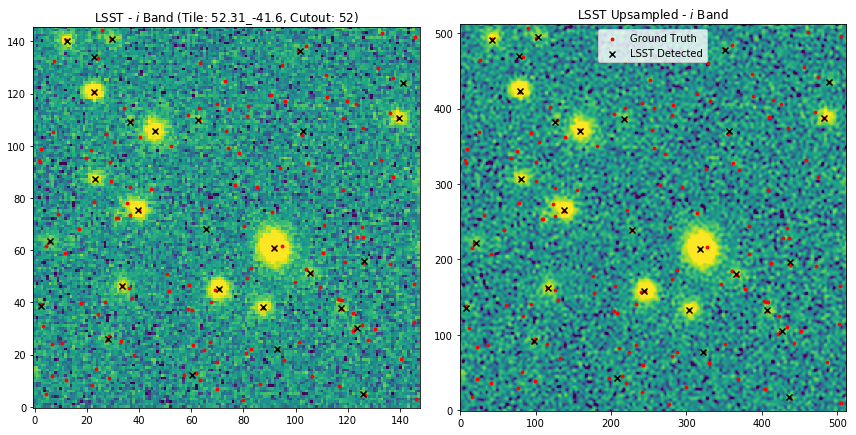


Random Cutout 2/3

Cutout Summary:
Tile: 52.40_-41.1
Cutout ID: 142
Is Empty: False

Image shapes:
  LSST: (6, 147, 148)
  LSST Upsampled: (6, 512, 512)

Object counts:
  Truth catalog: 159
  Detection catalog: 40
  Roman source: 168

Truth catalog info:
  Galaxies: 157
  Stars: 2
  SNe: 0

Detection catalog info:
  Extended sources: 34
  Point sources: 6
  Clean detections: 40


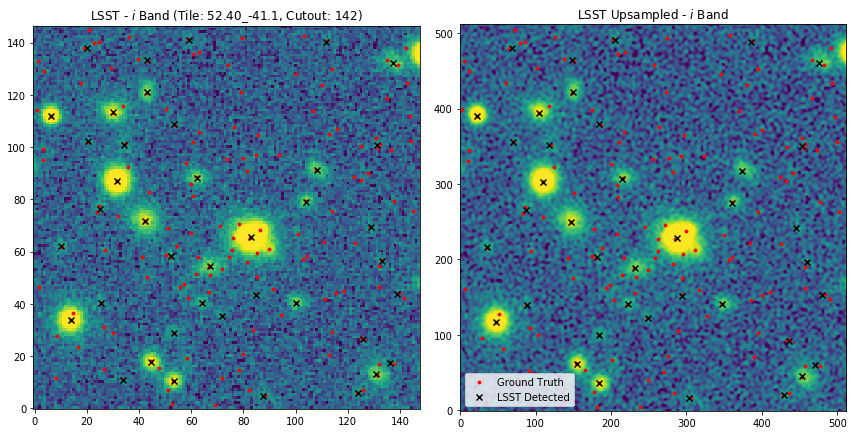


Random Cutout 3/3

Cutout Summary:
Tile: 54.31_-41.6
Cutout ID: 72
Is Empty: False

Image shapes:
  LSST: (6, 145, 147)
  LSST Upsampled: (6, 512, 512)

Object counts:
  Truth catalog: 147
  Detection catalog: 35
  Roman source: 153

Truth catalog info:
  Galaxies: 146
  Stars: 1
  SNe: 0

Detection catalog info:
  Extended sources: 29
  Point sources: 6
  Clean detections: 35


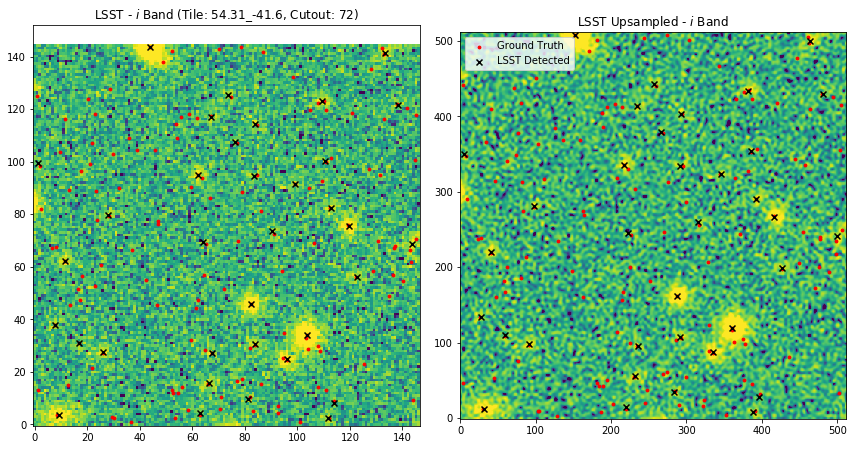

In [17]:
class CutoutVerifier:
    """Tool for randomly selecting and verifying cutouts from the processed data"""
    
    def __init__(self, root_dir='/pscratch/sd/y/yaswante/MyQuota/roman_lsst/'):
        self.root_dir = root_dir
        self.lsst_dir = f'{root_dir}truth-lsst/'
        self.lsst_ups_dir = f'{root_dir}truth-lsst-ups/'
        self.roman_dir = f'{root_dir}truth-roman/'
        
        self.all_tiles = [
            "51.53_-40.0", "51.37_-38.3", "52.31_-41.6", "52.40_-41.1", 
            "52.49_-39.1", "52.93_-40.8", "53.25_-41.8", "53.75_-38.9", 
            "54.24_-38.3", "54.31_-41.6", "55.03_-41.9", "55.54_-41.9",
            "56.06_-39.8"
        ]
        self.cutouts_per_tile = 225
        
    def get_random_cutout(self, tile=None, cutout_id=None, exclude_empty=True):
        """
        Get a random cutout. Can specify tile and/or cutout_id.
        
        Parameters:
        -----------
        tile : str, optional
            Specific tile to use. If None, randomly selects one.
        cutout_id : int, optional
            Specific cutout ID to use. If None, randomly selects one.
        exclude_empty : bool, default True
            If True, will retry until finding a non-empty cutout.
            
        Returns:
        --------
        dict : Dictionary containing all loaded data and metadata
        """
        
        attempts = 0
        max_attempts = 50 if exclude_empty else 1
        
        while attempts < max_attempts:
            # random tile if not specified
            if tile is None:
                selected_tile = random.choice(self.all_tiles)
            else:
                selected_tile = tile
                
            # random cutout ID if not specified
            if cutout_id is None:
                selected_cutout_id = random.randint(0, self.cutouts_per_tile - 1)
            else:
                selected_cutout_id = cutout_id
            
            # load the cutout
            result = self.load_cutout(selected_tile, selected_cutout_id)
            
            if result is not None:
                if not exclude_empty or not result['is_empty']:
                    return result
                    
            attempts += 1
            
            # specific tile/cutout was requested, don't retry with different ones
            if tile is not None or cutout_id is not None:
                break
                
        print(f"Could not find a valid cutout after {attempts} attempts")
        return None
    
    def load_cutout(self, tile, cutout_id):
        """Load all data for a specific cutout"""
        
        base_filename = f'c{cutout_id}_{tile}'
        paths = {
            'lsst_img': f'{self.lsst_dir}dc2_{tile}/full_{base_filename}.npy',
            'lsst_ups_img': f'{self.lsst_ups_dir}dc2_{tile}/full_{base_filename}.npy',
            'truth_cat': f'{self.lsst_dir}dc2_{tile}/truth_{base_filename}.json',
            'det_cat': f'{self.lsst_dir}dc2_{tile}/det_{base_filename}.json',
            'truth_cat_ups': f'{self.lsst_ups_dir}dc2_{tile}/truth_{base_filename}.json',
            'det_cat_ups': f'{self.lsst_ups_dir}dc2_{tile}/det_{base_filename}.json',
            'roman_truth': f'{self.roman_dir}{tile}/truth_{base_filename}.json'
        }
        if not os.path.exists(paths['lsst_img']):
            print(f"Cutout {cutout_id} from tile {tile} does not exist")
            return None
            
        try:
            lsst_img = np.load(paths['lsst_img'])
            lsst_ups_img = np.load(paths['lsst_ups_img'])
            is_empty = lsst_img.shape == (6, 0, 0)
            
            truth_cat = pd.read_json(paths['truth_cat']) if os.path.exists(paths['truth_cat']) else pd.DataFrame()
            det_cat = pd.read_json(paths['det_cat']) if os.path.exists(paths['det_cat']) else pd.DataFrame()
            truth_cat_ups = pd.read_json(paths['truth_cat_ups']) if os.path.exists(paths['truth_cat_ups']) else pd.DataFrame()
            det_cat_ups = pd.read_json(paths['det_cat_ups']) if os.path.exists(paths['det_cat_ups']) else pd.DataFrame()
            
            roman_truth = None
            if os.path.exists(paths['roman_truth']):
                roman_truth = pd.read_json(paths['roman_truth'])
            
            return {
                'tile': tile,
                'cutout_id': cutout_id,
                'lsst_img': lsst_img,
                'lsst_ups_img': lsst_ups_img,
                'truth_cat': truth_cat,
                'det_cat': det_cat,
                'truth_cat_ups': truth_cat_ups,
                'det_cat_ups': det_cat_ups,
                'roman_truth': roman_truth,
                'is_empty': is_empty,
                'paths': paths
            }
            
        except Exception as e:
            print(f"Error loading cutout {cutout_id} from tile {tile}: {e}")
            return None
    
    def plot_cutout(self, data, band='i', figsize=(12, 8)):
        """Plot a cutout using the standard visualization"""
        
        if data['is_empty']:
            print(f"Cutout {data['cutout_id']} from tile {data['tile']} is empty (was skipped during processing)")
            return
            
        band_indices = {'u': 0, 'g': 1, 'r': 2, 'i': 3, 'z': 4, 'y': 5}
        band_idx = band_indices.get(band, 3)  # default is i-band
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        lsst_band_img = data['lsst_img'][band_idx, :, :]
        axes[0].set_title(f"LSST - ${band}$ Band (Tile: {data['tile']}, Cutout: {data['cutout_id']})")
        axes[0].imshow(lsst_band_img, norm=asinh_norm(lsst_band_img, a=0.1), origin='lower', cmap='viridis')
        
        if not data['truth_cat'].empty:
            axes[0].scatter(data['truth_cat']['cutout_x'], data['truth_cat']['cutout_y'], 
                          color='red', s=8, label='Ground Truth')
        if not data['det_cat'].empty:
            axes[0].scatter(data['det_cat']['cutout_x'], data['det_cat']['cutout_y'], 
                          marker='x', color='black', label='LSST Detected')
        
        upsampled_band_img = data['lsst_ups_img'][band_idx, :, :]
        axes[1].set_title(f"LSST Upsampled - ${band}$ Band")
        axes[1].imshow(upsampled_band_img, norm=asinh_norm(upsampled_band_img, a=0.1), 
                      origin='lower', cmap='viridis')
        
        if not data['truth_cat_ups'].empty:
            axes[1].scatter(data['truth_cat_ups']['cutout_x'], data['truth_cat_ups']['cutout_y'], 
                          color='red', s=8, label='Ground Truth')
        if not data['det_cat_ups'].empty:
            axes[1].scatter(data['det_cat_ups']['cutout_x'], data['det_cat_ups']['cutout_y'], 
                          marker='x', color='black', label='LSST Detected')
        
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    def print_summary(self, data):
        """Print summary statistics for a cutout"""
        
        print(f"\nCutout Summary:")
        print(f"=" * 50)
        print(f"Tile: {data['tile']}")
        print(f"Cutout ID: {data['cutout_id']}")
        print(f"Is Empty: {data['is_empty']}")
        
        if not data['is_empty']:
            print(f"\nImage shapes:")
            print(f"  LSST: {data['lsst_img'].shape}")
            print(f"  LSST Upsampled: {data['lsst_ups_img'].shape}")
            
            print(f"\nObject counts:")
            print(f"  Truth catalog: {len(data['truth_cat'])}")
            print(f"  Detection catalog: {len(data['det_cat'])}")
            if data['roman_truth'] is not None:
                print(f"  Roman source: {len(data['roman_truth'])}")
            
            if not data['truth_cat'].empty:
                print(f"\nTruth catalog info:")
                print(f"  Galaxies: {len(data['truth_cat'][data['truth_cat']['truth_type'] == 1])}")
                print(f"  Stars: {len(data['truth_cat'][data['truth_cat']['truth_type'] == 2])}")
                print(f"  SNe: {len(data['truth_cat'][data['truth_cat']['truth_type'] == 3])}")
                
            if not data['det_cat'].empty:
                print(f"\nDetection catalog info:")
                print(f"  Extended sources: {len(data['det_cat'][data['det_cat']['extendedness'] > 0.5])}")
                print(f"  Point sources: {len(data['det_cat'][data['det_cat']['extendedness'] <= 0.5])}")
                print(f"  Clean detections: {len(data['det_cat'][data['det_cat']['clean'] == True])}")

def quick_verify(n_random=5):
    """Quickly verify n random cutouts"""
    verifier = CutoutVerifier()
    
    for i in range(n_random):
        print(f"\n{'='*60}")
        print(f"Random Cutout {i+1}/{n_random}")
        print(f"{'='*60}")
        
        data = verifier.get_random_cutout(exclude_empty=True)
        if data:
            verifier.print_summary(data)
            verifier.plot_cutout(data)

def verify_specific(tile, cutout_id):
    """Verify a specific cutout"""
    verifier = CutoutVerifier()
    data = verifier.load_cutout(tile, cutout_id)
    
    if data:
        verifier.print_summary(data)
        if not data['is_empty']:
            verifier.plot_cutout(data)
    else:
        print(f"Could not load cutout {cutout_id} from tile {tile}")

def interactive_verify():
    """Interactive verification mode"""
    verifier = CutoutVerifier()
    
    while True:
        print("\n" + "="*60)
        print("Cutout Verification Tool")
        print("="*60)
        print("1. Random cutout")
        print("2. Specific cutout")
        print("3. Random cutout from specific tile")
        print("4. Exit")
        
        choice = input("\nEnter choice (1-4): ")
        
        if choice == '1':
            data = verifier.get_random_cutout(exclude_empty=True)
            if data:
                verifier.print_summary(data)
                verifier.plot_cutout(data)
                
        elif choice == '2':
            tile = input("Enter tile (e.g., 51.53_-40.0): ")
            cutout_id = int(input("Enter cutout ID (0-224): "))
            data = verifier.load_cutout(tile, cutout_id)
            if data:
                verifier.print_summary(data)
                if not data['is_empty']:
                    verifier.plot_cutout(data)
                    
        elif choice == '3':
            print("\nAvailable tiles:")
            for i, tile in enumerate(verifier.all_tiles):
                print(f"  {i}: {tile}")
            tile_idx = int(input("Enter tile index: "))
            tile = verifier.all_tiles[tile_idx]
            data = verifier.get_random_cutout(tile=tile, exclude_empty=True)
            if data:
                verifier.print_summary(data)
                verifier.plot_cutout(data)
                
        elif choice == '4':
            break
            
        else:
            print("Invalid choice")

if __name__ == "__main__":
    quick_verify(3)


Cutout Verification Tool
1. Random cutout
2. Specific cutout
3. Random cutout from specific tile
4. Exit



Enter choice (1-4):  1



Cutout Summary:
Tile: 53.75_-38.9
Cutout ID: 70
Is Empty: False

Image shapes:
  LSST: (6, 146, 147)
  LSST Upsampled: (6, 512, 512)

Object counts:
  Truth catalog: 137
  Detection catalog: 31
  Roman source: 147

Truth catalog info:
  Galaxies: 136
  Stars: 1
  SNe: 0

Detection catalog info:
  Extended sources: 22
  Point sources: 9
  Clean detections: 30


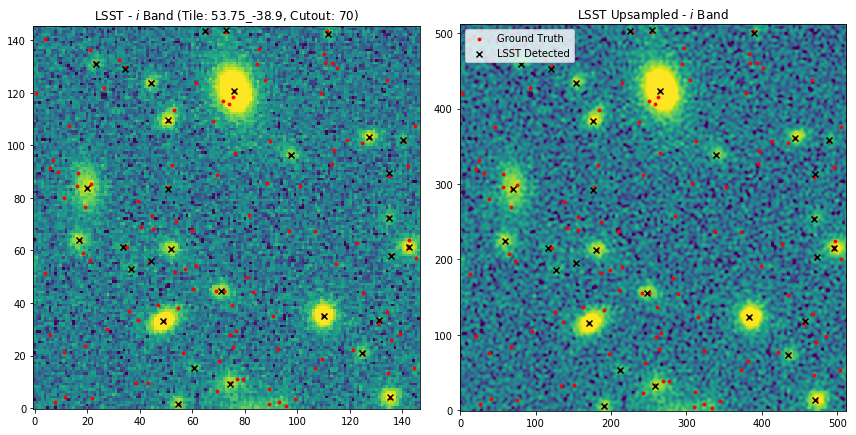


Cutout Verification Tool
1. Random cutout
2. Specific cutout
3. Random cutout from specific tile
4. Exit



Enter choice (1-4):  1



Cutout Summary:
Tile: 51.37_-38.3
Cutout ID: 88
Is Empty: False

Image shapes:
  LSST: (6, 147, 147)
  LSST Upsampled: (6, 512, 512)

Object counts:
  Truth catalog: 125
  Detection catalog: 25
  Roman source: 134

Truth catalog info:
  Galaxies: 124
  Stars: 1
  SNe: 0

Detection catalog info:
  Extended sources: 18
  Point sources: 7
  Clean detections: 25


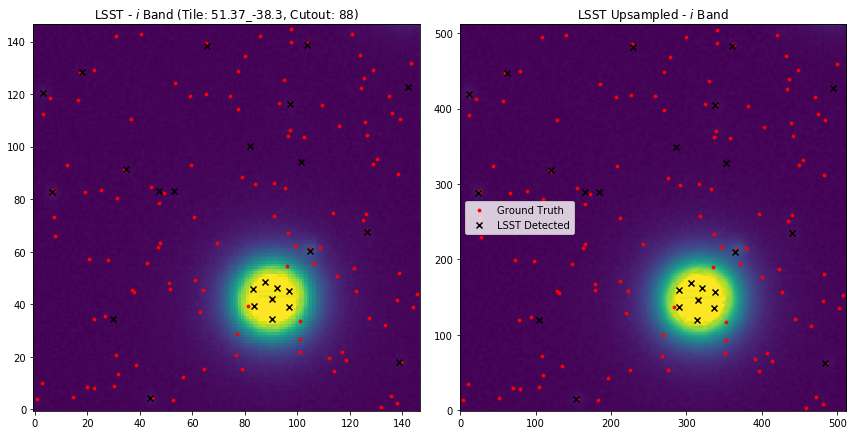


Cutout Verification Tool
1. Random cutout
2. Specific cutout
3. Random cutout from specific tile
4. Exit



Enter choice (1-4):  4


In [18]:
interactive_verify()

In [65]:
lsst_img = np.load('/pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst/dc2_51.34_-41.3/full_c1_51.34_-41.3.npy')
lsst_ups_img = np.load('/pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst-ups/dc2_51.34_-41.3/full_c1_51.34_-41.3.npy')
print(lsst_img.shape)
print(lsst_ups_img.shape)

truth_cat = pd.read_json('/pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst/dc2_51.34_-41.3/truth_c1_51.34_-41.3.json')
det_cat = pd.read_json('/pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst/dc2_51.34_-41.3/det_c1_51.34_-41.3.json')

truth_cat_ups = pd.read_json('/pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst-ups/dc2_51.34_-41.3/truth_c1_51.34_-41.3.json')
det_cat_ups = pd.read_json('/pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst-ups/dc2_51.34_-41.3/det_c1_51.34_-41.3.json')

(6, 149, 148)
(6, 512, 512)


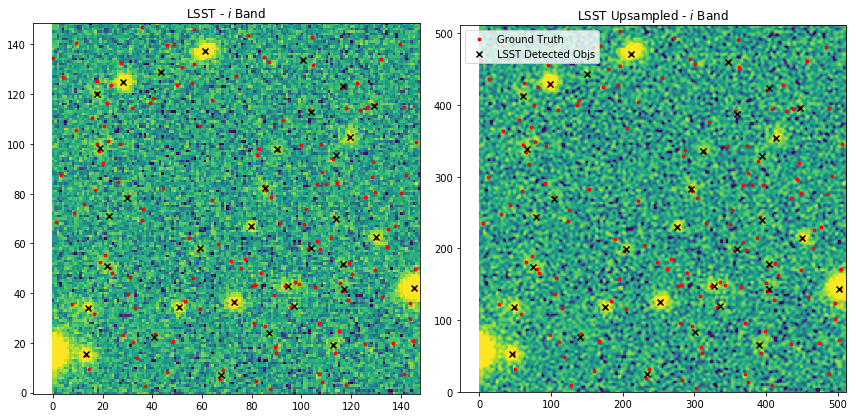

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
lsst_iband_img = lsst_img[3, :, :] # lsst i-band img
axes[0].set_title(r'LSST - $i$ Band')
axes[0].imshow(lsst_iband_img, norm=asinh_norm(lsst_iband_img, a=0.1), origin='lower', cmap='viridis')
axes[0].scatter(truth_cat['cutout_x'], truth_cat['cutout_y'], color=['red'], s=8, label='Ground Truth')
axes[0].scatter(det_cat['cutout_x'], det_cat['cutout_y'], marker='x', color=['black'], label='LSST Detected Objs')


upsampled_iband_img = lsst_ups_img[3, :, :]
axes[1].set_title(r'LSST Upsampled - $i$ Band')
axes[1].imshow(upsampled_iband_img, norm=asinh_norm(upsampled_iband_img, a=0.1), origin='lower', cmap='viridis')
axes[1].scatter(truth_cat_ups['cutout_x'], truth_cat_ups['cutout_y'], color=['red'], s=8, label='Ground Truth')
axes[1].scatter(det_cat_ups['cutout_x'], det_cat_ups['cutout_y'], marker='x', color=['black'], label='LSST Detected Objs')

plt.legend()
plt.tight_layout()

(6, 147, 147)
(6, 512, 512)


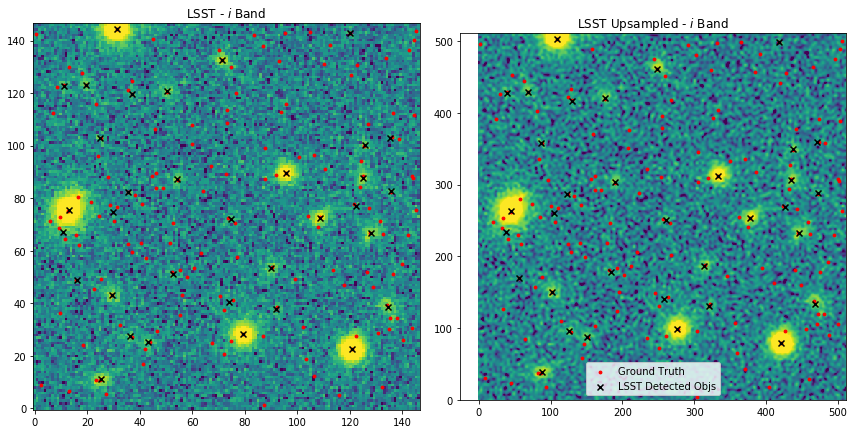

In [72]:
lsst_img = np.load('/pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst/dc2_51.34_-41.3/full_c200_51.34_-41.3.npy')
lsst_ups_img = np.load('/pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst-ups/dc2_51.34_-41.3/full_c200_51.34_-41.3.npy')
print(lsst_img.shape)
print(lsst_ups_img.shape)

truth_cat = pd.read_json('/pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst/dc2_51.34_-41.3/truth_c200_51.34_-41.3.json')
det_cat = pd.read_json('/pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst/dc2_51.34_-41.3/det_c200_51.34_-41.3.json')

truth_cat_ups = pd.read_json('/pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst-ups/dc2_51.34_-41.3/truth_c200_51.34_-41.3.json')
det_cat_ups = pd.read_json('/pscratch/sd/y/yaswante/MyQuota/roman_lsst/truth-lsst-ups/dc2_51.34_-41.3/det_c200_51.34_-41.3.json')

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
lsst_iband_img = lsst_img[3, :, :] # lsst i-band img
axes[0].set_title(r'LSST - $i$ Band')
axes[0].imshow(lsst_iband_img, norm=asinh_norm(lsst_iband_img, a=0.1), origin='lower', cmap='viridis')
axes[0].scatter(truth_cat['cutout_x'], truth_cat['cutout_y'], color=['red'], s=8, label='Ground Truth')
axes[0].scatter(det_cat['cutout_x'], det_cat['cutout_y'], marker='x', color=['black'], label='LSST Detected Objs')


upsampled_iband_img = lsst_ups_img[3, :, :]
axes[1].set_title(r'LSST Upsampled - $i$ Band')
axes[1].imshow(upsampled_iband_img, norm=asinh_norm(upsampled_iband_img, a=0.1), origin='lower', cmap='viridis')
axes[1].scatter(truth_cat_ups['cutout_x'], truth_cat_ups['cutout_y'], color=['red'], s=8, label='Ground Truth')
axes[1].scatter(det_cat_ups['cutout_x'], det_cat_ups['cutout_y'], marker='x', color=['black'], label='LSST Detected Objs')

plt.legend()
plt.tight_layout()